    TOPIC: Beyond News Headlines and TF-IDF: Enhancing Text-Based Forecasting Models with Validated Collocations and Improved Attention.
    Author : Gabriel Appau Abeyie.

    Explanation for Code Block 1:
This code block is dedicated to importing the necessary libraries and modules needed for our research. Below is a brief description of some of the 
important imports:

**nltk**: This library is used for working with human language data. It provides easy-to-use interfaces to over 50 corpora and lexical resources.

**numpy** and **pandas**: These libraries are used for handling and manipulating the dataset. numpy is used for mathematical calculations, 
and pandas is used for data manipulation and analysis.

**statsmodels**: This library is used to estimate and interpret models for statistical analysis.

**matplotlib**: This library is used for plotting and visualization of the data.

**scikit-learn (sklearn)**: This library is used for machine learning and statistical modeling. It provides various tools for model fitting, 
data preprocessing, model selection and evaluation, and many other utilities.

**scipy**: This library is used for scientific and technical computing. It provides functions for mathematical operations, statistical analysis, and more.

**wordcloud**: This library is used for visualizing word frequency by generating word clouds.

**arabica**: This library is used for exploratory text data analaysis.

**yfinance**: This library is used to fetch financial data.

**fredapi**: This library is used for accessing economic data from the Federal Reserve Economic Data (FRED) database.

**NOTE**: The code block also sets up fredapi with an API key (placeholder is given as 'YOUR_FRED_API_KEY_HERE') and overrides pandas' 
datareader methods to use yfinance instead, which is used for downloading historical market data from Yahoo! Finance.

In [10]:
import sys
import glob
import nltk
import unicodedata
import re
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from nltk import ngrams
from collections import Counter
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import f_regression
from scipy.stats import chi2_contingency
from sklearn.metrics import mean_squared_error
from itertools import product
from math import sqrt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
from scipy.stats import ttest_1samp
from tabulate import tabulate
from statsmodels.tsa.ar_model import AutoReg
from matplotlib.patches import Rectangle
from bs4 import BeautifulSoup
from arabica import arabica_freq
from wordcloud import WordCloud, STOPWORDS
from dieboldmariano import dm_test
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from arabica import cappuccino
from arabica import coffee_break
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk import ne_chunk
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from scipy import stats
from pandas_datareader import data as pdr
from fredapi import Fred
fred = 'YOUR_FRED_API_KEY_HERE'
import yfinance as yf
yf.pdr_override()

    Explanation for Code Block 2:
This block of code is focused on retrieving and processing the oil price data. The data is retrieved from FRED

In [11]:
oil_price = fred.get_series('DCOILWTICO', observation_start='1986-01-01', observation_end='2017-12-01')
monthly_oil = oil_price.resample('M').mean().ffill()
monthly_oil_log = np.log(monthly_oil)
monthly_oil_log_diff = monthly_oil_log.diff()
monthly_oil_log_diff = monthly_oil_log_diff.dropna()
print(monthly_oil_log_diff.head())

1986-02-28   -0.394332
1986-03-31   -0.203227
1986-04-30    0.018160
1986-05-31    0.180065
1986-06-30   -0.135741
Freq: M, dtype: float64


    Explanation for Code Block 3:
This block of code is used for visualizing the monthly log differences in oil prices along with the periods of recessions in the U.S.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


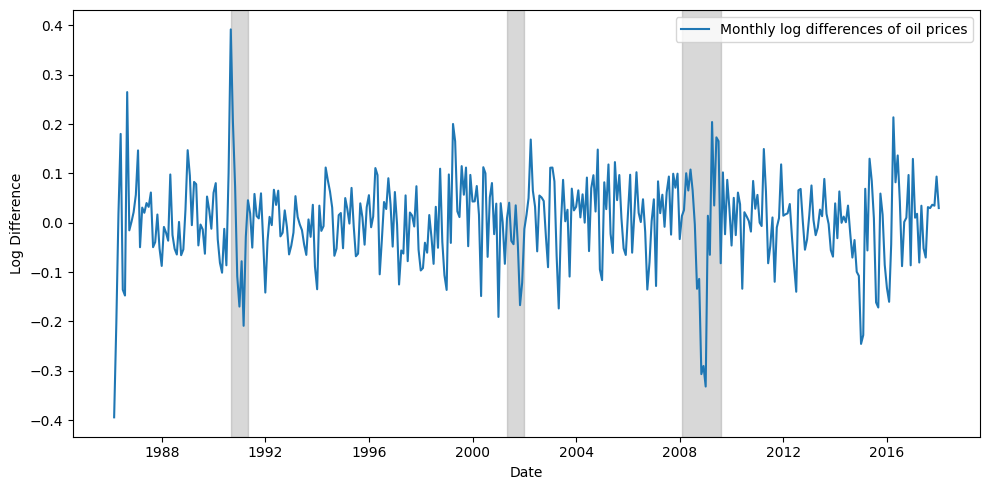

In [12]:
recessions = fred.get_series('USREC', observation_start='1986-01-01', observation_end='2017-12-01')
recessions = recessions.resample('M').last().ffill()

plt.figure(figsize=(10, 5))
plt.plot(monthly_oil_log_diff, label='Monthly log differences of oil prices')

for start, end in zip(recessions.index[recessions.diff() == 1], recessions.index[recessions.diff() == -1]):
    plt.axvspan(start, end, color='gray', alpha=0.3)

plt.xlabel('Date')
plt.ylabel('Log Difference')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.savefig('target.eps', dpi=600)
plt.show()

    Explanation for Code Block 4:
    
This code block is focused on retrieving and processing the Sahm Rule Recession Indicator, a real-time recession indicator based on unemployment data.

In [13]:
# Get the Sahm Rule Recession Indicator
sahn_index = fred.get_series('SAHMREALTIME', observation_start='1986-02-01', observation_end='2017-12-01')

# Initialize recession_expansion and update as matrices of True
recession_expansion = pd.DataFrame(True, index=sahn_index.index, columns=['indicator'])
update = recession_expansion.copy()

# Update recession_expansion: set to False if Sahm Rule Recession Indicator > 0.5
recession_expansion.loc[sahn_index > 0.5, 'indicator'] = False

# Update the update matrix: set to True only for the first time point and whenever the value of recession_expansion changes
update['indicator'] = recession_expansion['indicator'].ne(recession_expansion['indicator'].shift())
update['indicator'].iloc[0] = True

    Explanation for Code Block 5:
This block of code is concerned with loading datasets and preparing the target variable for further analysis.

In [14]:
Features = pd.read_csv('D:/Python/Untitled Folder/df1.csv')
FREDMD = pd.read_csv('D:/Python/Untitled Folder/fredmd.csv')
NewsHeadlines = pd.read_csv('D:/Python/Untitled Folder/NewHeadlines.csv')
Target = monthly_oil_log_diff.values.ravel()  # This converts the target DataFrame to a 1D array

    Explanation for Code Block 6:
This block of code is dedicated to text cleaning by correcting specific word forms in the Features DataFrame. The objective is to ensure that the text data is consistent and free from certain types of errors or variations.

In [15]:
# This creates a dictionary mapping the incorrect forms to the correct ones
correction_dict = {
    "accord ing": "according",
    "interna tional": "international",
    "administra tion": "administration",
    "air line": "airline",
    "bar rel": "barrel",
    "invest ment": "investment",
    "bil lion": "billion",
    "mil lion": "million",
    "com pared": "compared",
    "com modities":"commodity",
    "commod ity": "commodity",
    "expecta tions": "expectation",
    "percent age": "percentage",
    "yorkcrude": "york crude",
    "ear lier": "earlier",
    "earn ings": "earnings",
    "econo mist": "economist",
    "euro pean": "european",
    "bar rels": "barrel",
    "pro ducer": "producer",
    "pro ducers": "producer",
    "pro gram": "program",
    "prob lem": "problem",
    "pro duction": "production",
    "daq": "nasdaq",
    "nasnasnasdaq": "nasdaq",
    "fri day": "friday",
    "fourth quarter": "fourthquarter",
    "prod ucts": "product",
    "quar ter": "quarter",
    "chi cago": "chicago",
    "ri ing": "rising",
    "sec ond": "second",
    "sec tor": "sector",
    "securi ties": "securitie",
    "securi tie": "securitie",
    "execu tive": "executive",
    "invest ment": "investment",
    "decem ber": "december",
    "janu ary": "january",
    "mar ket": "market",
    "sev eral": "several",
    "inven tory": "inventory",
    "sell ing": "selling",
    "trad er": "trader",
    "trad ing": "trading",
    "vol ume": "volume",
    "trea sury": "treasury",
    "invento ries": "inventory",
    "inves tor": "investor",
    "web site": "website",
    "invest ment": "investment",
    "invest ments": "investment",
    "yester day": "yesterday",
    "yes terday": "yesterday",
    "wednes day": "wednesday",
    "mer cantile": "mercantile",
    "mercan tile": "mercantile",
    "tues day": "tuesday",
    "mil lion": "million",
    "novem ber": "november",
    "sum mer": "summer",
    "stockindex": "stock index",
    "washingtonpost": "washington post",
    "contin ued": "continued",
    "crudeoil": "crude oil",
    "nasnasdaq": "nasdaq",
    "minuteminute": "minute minute",
    "futuresoptions": "future option",
    "includ ing": "including",
    "inter national": "international",
    "naturalgas": "natural gas",
    "oilbarrel": "oil barrel",
    "outnum bered": "outnumbered",
    "pres sure": "pressure",
    "presi dent": "president",
    "terest": "interest",
    "thur day": "thursday",
    "sup ply": "supply",
    "soy bean": "soybean",
    "inininterest": "interest",
    "ininterest": "interest",
    "fore cast": "forecast",
    "reve nue": "revenue",
    "peo ple": "people",
    "aver age": "average",
    "petro leum": "petroleum",
    "organiza tion": "organization",
    "pipe line": "pipeline",
    "nat ural": "natural",
    "ana lyst": "analyst",
    "ana lysts": "analyst",
    "buy ing": "buying",
    "natu ral": "natural",
    "busi ness": "business",
    "chair man": "chairman",
    "produc tion": "production",
    "ex porting": "exporting",
    "com panies": "company",
    "ara bia": "arabia",
    "larg est": "largest",
    "mem bers": "member",
    "mon day": "monday",
    "com pany": "company",
    "sep tember": "september",
    "septem ber": "september",
    "compa ny": "company",
    "com modity": "commodity",
    "ser vice": "service",
    "ser vices": "service",
    "set tled": "settled",
    "stan dard": "standard",
    "japa nese": "japanese",
    "eco nomic": "economic",
    "commodi tie": "commodity",
    "com posite": "composite",
    "compos ite": "composite",
    "cur rency": "currency",
    "cur rent": "current",
    "bench mark": "benchmark",
    "coun try": "country",
    "fed eral": "federal",
    "japa nese": "japanese",
    "export ing": "exporting",
    "deliv ery": "delivery",
    "depart ment": "department",
    "heatingoil": "heating oil",
    "heat ing": "heating",
    "bluechip": "blue chip",
    "divi sion": "division",
    "dol lar": "dollar",
    "dur ing": "during",
    "harmon": "harman",
    "inter est": "interest",
    "econ omy": "economy",
    "esti mate": "estimate",
    "febru ary": "february",
    "finan cial": "financial",
    "fur ther": "further",
    "gal lon": "gallon",
    "investment officer albany": "investment officer first albany",
    "point face yield": "face yield",
    "gaso line": "gasoline",
    "glo bal": "global",
    "second quarter": "secondquarter",
    "smaller company": "smallercompany", 
    "govern ment": "government",
    "gov ernment": "government",
    "include ing": "including",
    "indus trial": "industrial",
    "indus try": "industry",
    "infla tion": "inflation",
    "novem ber": "november",
    "octo ber": "october",
    "organi zation": "organization",
    "offi cials": "official",
    "manage ment": "management",
    "tech nology": "technology",
    "big gest": "biggest",
    "opera tions": "operation",
    "insti tute": "institute",
    "prec metal indus": "precious metal industry",
    "york stock change": "york stock exchange",
    "mor gan": "morgan"
}

# define a function to apply the corrections
def correct_words(text):
    for incorrect, correct in correction_dict.items():
        text = text.replace(incorrect, correct)
    return text

# apply the function to your text column
Features['cleaned_Text'] = Features['cleaned_Text'].apply(correct_words)

    Explanation for Code Block 7:
This block of code is involved in preparing a corpus for further text analysis and generating date ranges for time-series analysis.

In [16]:
corpus = ' '.join(Features['cleaned_Text'])
# Generate dates for x-axis
base_dates = pd.date_range(start="1986-01", end="2017-12", freq='M')
oos_base_dates = pd.date_range(start="2006-01", end="2018-01", freq='M')

    Explanation for Code Block 8:

This code block defines a function for extracting n-grams from the text data and converting them into a numerical format suitable for machine learning models. The function also splits the data into training and testing sets and processes them separately to avoid data leakage.

In [17]:
def get_ngramrange_df(df, min_df, tfidf_min, split_ratio, ngram_range):
    # Split the data based on split ratio
    split_index = int(len(df) * split_ratio)
    df_train = df.iloc[:split_index]
    df_test = df.iloc[split_index:]

    # Create an instance of the TfidfVectorizer class with specified ngram range
    vectorizer_tfidf_combined = TfidfVectorizer(analyzer="word", ngram_range=ngram_range, min_df=min_df, stop_words='english')

    # Fit the vectorizer on the training dataset and transform training dataset
    X_tfidf_train = vectorizer_tfidf_combined.fit_transform(df_train['cleaned_Text'])
    
    # Convert the resulting matrices to DataFrames with appropriate column names
    columns = vectorizer_tfidf_combined.get_feature_names_out()
    df_tfidf_train = pd.DataFrame(X_tfidf_train.toarray(), columns=columns)

    # Calculate the total sum of TF-IDF values for each n-gram and filter n-grams with total TF-IDF >= 1.0
    df_total_tfidf = df_tfidf_train.sum().reset_index()
    df_total_tfidf.columns = ['ngram', 'total_tfidf']
    ngrams_with_total_tfidf_above_one = df_total_tfidf[df_total_tfidf['total_tfidf'] >= tfidf_min]['ngram'].tolist()

    # Create a CountVectorizer instance using the filtered n-grams
    vectorizer_count = CountVectorizer(vocabulary=ngrams_with_total_tfidf_above_one, ngram_range=ngram_range, stop_words='english')

    # Fit and transform the data using the count vectorizer
    X_count_train = vectorizer_count.fit_transform(df_train['cleaned_Text'])
    X_count_test = vectorizer_count.transform(df_test['cleaned_Text'])

    # Convert the resulting matrices to DataFrames with appropriate column names
    df_count_train = pd.DataFrame(X_count_train.toarray(), columns=vectorizer_count.get_feature_names_out())
    df_count_test = pd.DataFrame(X_count_test.toarray(), columns=vectorizer_count.get_feature_names_out())

    return df_count_train, df_count_test

    Explanation for Code Block 9:
This block of code is applying the get_ngramrange_df function to the Features and NewsHeadlines DataFrames to extract n-gram features and split the data into training and testing sets. Note that the choice of **min_df** and **tfidf_min** is determined by cross validation. See **tfidf.ipynb** for the code.

In [18]:
X_train, X_test = get_ngramrange_df(Features, ngram_range =(1,2), min_df=0.06, tfidf_min=0.80, split_ratio=0.625)
News_train, News_test = get_ngramrange_df(NewsHeadlines, ngram_range =(1,1), min_df=0.06, tfidf_min=1.00, split_ratio=0.625)
X_columns = X_train.columns.tolist()

    Explanation for Code Block 10:
This block of code is dedicated to segregating the n-gram features into separate lists of unigrams and bigrams. This categorization helps in understanding the distribution and contribution of single words (unigrams) versus two-word phrases (bigrams) in the dataset.

In [20]:
# Initialize lists for unigrams and bigrams
unigrams = []
bigrams = []

# Split X_columns into unigrams and bigrams
for phrase in X_columns:
    words = phrase.split(' ')
    if len(words) == 1:
        unigrams.append(phrase)
    elif len(words) == 2:
        bigrams.append(phrase)
    else:
        print(f"Unexpected number of words in phrase: {phrase}")

    Explanation for Code Block 11: **VALIDATING COLLOCATIONS**
This code block is centered around validating the bigrams by ensuring they follow specific part-of-speech patterns. This process is essential for confirming that the bigrams represent meaningful and grammatically valid combinations of words.

In [21]:
# Validating the collocations

#Justeson and Katz pattern
def is_adj_noun_or_noun_noun(ngram):
    words = nltk.word_tokenize(ngram)
    pos_tags = [tag for word, tag in nltk.pos_tag(words)]
    # Check for adjective + noun or noun + noun patterns
    return (pos_tags == ['JJ', 'NN'] or pos_tags == ['NN', 'NN'])

#verb-Noun and Adverb-Adjective pattern
def is_verb_noun_or_adv_adj(bigram):
    words = nltk.word_tokenize(bigram)
    pos_tags = [tag for word, tag in nltk.pos_tag(words)]
    # Check for verb + noun, adverb + adjective, and noun + verb
    return pos_tags in [['VB', 'NN'], ['VBD', 'NN'], ['VBG', 'NN'], ['VBN', 'NN'], ['VBP', 'NN'], ['VBZ', 'NN'], 
                        ['RB', 'JJ'], ['RBR', 'JJ'], ['RBS', 'JJ']]
    
# Use the function to filter bigrams
jk_bigrams = [bigram for bigram in bigrams if is_adj_noun_or_noun_noun(bigram)]
vn_bigrams = [bigram for bigram in bigrams if is_verb_noun_or_adv_adj(bigram)]

    Explanation for Code Block 12:
This code block is responsible for combining the validated bigrams with the unigrams to form two new sets of features for further analysis or modeling.

In [22]:
X_jk_columns = unigrams + jk_bigrams
X_vn_columns = unigrams + vn_bigrams

    Explanation for Code Block 13:
This code block is focused on preparing multiple datasets for model training and testing by subsetting the original datasets based on various feature sets. This step ensures that the models can be trained and tested on different combinations of features (unigrams, jk_bigrams, and vn_bigrams) to evaluate their performance.

In [23]:
X_unigrams_only_train = X_train[unigrams]
X_unigrams_only_test = X_test[unigrams]
X_jk_train = X_train[X_jk_columns]
X_jk_test = X_test[X_jk_columns]
X_vn_train = X_train[X_vn_columns]
X_vn_test = X_test[X_vn_columns]

    Explanation for Code Block 14:
This code block is about creating a fixed dictionary of keywords that are known to influence crude oil prices, according to research by Loughran (2019). This dictionary is stored in a list called Fixed_Dictionary. The keywords in the dictionary include terms related to various aspects of oil production and distribution, such as "Attack", "Outage", "Production", "Pumping", "Refinery", "Supply", and many others.

In [24]:
Fixed_Dictionary = ["Attack", "Outage", "Discovered", "Allotment", "Producing", "Attacker", "Outages", "Discoveries", "Allotments", "Production", "Attackers", "Problem", "Discovery", "Buying", "Pumping", "Attacks",
                    "Problematic", "Glut", "Capacities", "Pumpings", "Bomb", "Problematicly", "Gluts", "Cargo", "Quota", "Bombed", "Problems", "Mistrust", "Cargoe", "Quotas", "Refineries", "Bomber", "Recoveries", "Overproducer",
                    "Cargoes", "Refinery", "Bombers", "Recovery", "Overproducers", "Constructing", "Reserves", "Bombing", "Sabotage", "Overproducing", "Construction", "Rig", "Bombings", "Sabotages", "Overproduction",
                    "Consumption", "Rigs", "Bombs", "Shortage", "Oversupplied", "Demand", "Stock", "Closures", "Shortages", "Oversupply", "Demands", "Stockpile", "Concerned", "Storm", "Oversupplying", "Difficulties",
                    "Stockpiles", "Conflict", "Storms", "Recession", "Drilling", "Stocks", "Conflicts", "Strike", "Recessions", "Drillings", "Supplies", "Cutback", "Strikers", "Repaired", "Economic", "Supply", "Cutbacks",
                    "Strikes", "Repairing", "Economies", "Temperature", "Delay", "Tension", "Surplus", "Economy", "Temperatures", "Delayed", "Tensions", "Surpluses", "Embargo", "Weather", "Delaying", "Turmoil", "Exploration",
                    "Delays", "Turmoils", "Export", "Dispute", "Unrest", "Exports", "Disputed", "Upheaval", "Import", "Disputes", "Upheavals", "Imports", "Disruptions", "Withdraw", "Inventories", "Explosion", "Withdrawing",
                    "Inventory", "Explosions", "Withdrawn", "Output", "Fire", "Outputs", "Fires", "Pipeline", "Hurricane", "Pipelines", "Hurricanes", "Platform", "Instability", "Platforms"]

    Explanation for Code Block 15:
This block of code is dedicated to preprocessing the Fixed_Dictionary to ensure consistency and remove redundancy in the keywords.

In [25]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Convert each word to lowercase and lemmatize it
lemmatized_list = [lemmatizer.lemmatize(word.lower()) for word in Fixed_Dictionary]

# Convert the list to a set and back to a list to remove duplicates
final_list = list(set(lemmatized_list))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gabeyie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


    Explanation for Code Block 16:

This code block is centered around counting the frequency of each keyword from the final_list (lemmatized and unique keywords from Fixed_Dictionary) in the cleaned_Text column of the Features DataFrame.

In [26]:
from collections import Counter

# Create a list to store dictionaries
dict_list = []

# Iterate over rows in the original dataframe
for index, row in Features.iterrows():
    # Get the text for the current row
    text = row['cleaned_Text']
    
    # Split the text into words
    words = text.split()
    
    # Count the frequency of each word
    word_counts = Counter(words)
    
    # Initialize a dictionary to hold the counts for the words in your list
    count_dict = {}
    
    # For each word in your list, get its count and add to the dictionary
    for word in final_list:
        count_dict[word] = word_counts.get(word, 0)
    
    # Add the dictionary to the list
    dict_list.append(count_dict)

# Convert the list of dictionaries into a dataframe
df_counts = pd.DataFrame(dict_list)

    Explanation for Code Block 17:
This block of code is focused on splitting the Fixed and FREDMD dataframes into training and testing sets. This is a standard procedure in machine learning and statistical modeling to evaluate the performance of models on unseen data.

In [27]:
Fixed = df_counts
split_ratio = 0.625
split_index = int(len(Fixed)*split_ratio)
Fixed_train = Fixed.iloc[:split_index]
Fixed_test = Fixed.iloc[split_index:]
Fredmd_train = FREDMD.iloc[:split_index]
Fredmd_test = FREDMD.iloc[split_index:]

    Explanation for Code Block 18:
This block of code is involved in further preparing the datasets for model training and testing.

In [28]:
import numpy as np

# Remove first row of the training sets. Since we used the monthly log difference of crude oil prices, we loose January 1986. The original data starts from January 1986.
X_unigrams_only_train = X_unigrams_only_train.iloc[1:, :]
X_train = X_train.iloc[1:, :]
X_jk_train = X_jk_train.iloc[1:, :]
X_vn_train = X_vn_train.iloc[1:, :]
Fixed_train = Fixed_train.iloc[1:, :]
Fredmd_train = Fredmd_train.iloc[1:, :]
News_train = News_train.iloc[1:, :]

# Convert all sets to arrays
X_unigrams_only_train = np.array(X_unigrams_only_train)
X_unigrams_only_test = np.array(X_unigrams_only_test)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_jk_train = np.array(X_jk_train)
X_jk_test = np.array(X_jk_test)
X_vn_train = np.array(X_vn_train)
X_vn_test = np.array(X_vn_test)
Fixed_train = np.array(Fixed_train)
Fixed_test = np.array(Fixed_test)
Fredmd_train = np.array(Fredmd_train)
Fredmd_test = np.array(Fredmd_test)
News_train = np.array(News_train)
News_test = np.array(News_test)

    Explanation for Code Block 19:
In this block of code, two dictionaries, datasets and datasets2, are being created to organize various datasets used in the project into a structured format. This organization makes it easier to iterate over the datasets for further processing, analysis, or modeling.

In [29]:
datasets = {r'Targeted Features ($D^{*}_{1,t}$)': (X_train, X_test),
            r'N-N/A-N Targeted Features ($D^{*}_{2,t}$)': (X_jk_train, X_jk_test),
            r'V-N/Av-A Targeted Features ($D^{*}_{3,t}$)':(X_vn_train, X_vn_test),
            r'News Headline Features ($D^{*}_{4,t}$)': (News_train, News_test)
            }

datasets2 = {r'Unigram Features ($D_{5,t}$)': (X_unigrams_only_train, X_unigrams_only_test),
             r'Fixed Dictionary Features ($D_{6,t}$)': (Fixed_train, Fixed_test),
             r'Untargeted FRED-MD Features ($D_{7,t}$)': (Fredmd_train, Fredmd_test),
             r'Untargeted Features ($D_{8,t}$)': (X_train, X_test)
            }


    Explanation for Code Block 20 and 21: num_factors Function
In this block, the num_factors function is defined to estimate the optimal number of factors to retain from a dataset based on its eigenvalues. The function performs an eigendecomposition and then uses a ratio of consecutive eigenvalues to determine the number of factors.

To determine the number of factors to employ in our principal component analysis (PCA), we adopt a method proposed by Ahn and Horstein (2013) and select upto the second largest (to be conservative) Eigen-value Ratio (ER) or Growth Ratio (GR) for robustness check. We set our $kmax$ to 8. Below are the formulas:
$$
\mathrm{ER}(k) \equiv \frac{\tilde{\mu}_{N T \cdot k}}{\tilde{\mu}_{N T, k+1}}, \quad k=1,2, \ldots, k \max
$$

$$
\begin{aligned}
\operatorname{GR}(k) & =\frac{\ln [V(k-1) / V(k)]}{\ln [V(k) / V(k+1)]} \\
& =\frac{\ln \left(1+\bar{\mu}_{N T_k}^*\right)}{\ln \left(1+\bar{\mu}_{N T, k+1}\right)}, \quad k=1,2, \ldots, k \max ,
\end{aligned}
$$
Where $V(k)=\sum_{l=k+1}^m \tilde{\mu}_{N T, f}$ and $\tilde{\mu}_{N T k}^*=\tilde{\mu}_{N T, k} / V(k)$.

In [30]:
def num_factors(data, kmax):
    T, N = data.shape
    K = min(kmax, N)

    xx = (data.T @ data) / (T*N) if N < T else (data @ data.T) / (T*N)

    eig_values = np.linalg.eigvals(xx)
    d = sorted(eig_values, reverse=True)

    ER = [d[k] / d[k+1] for k in range(K-1)]
    ER = [0 if np.isnan(e) or np.isinf(e) else e for e in ER]
    
    #n_fac = max(ER)
    n_fac = np.partition(ER, -2)[-2]
    
    num_factors = ER.index(n_fac) + 1 # Remember python indexing starts from 0 so +1

    return num_factors

In [31]:
def num_factors_gr(data, kmax):
    T, N = data.shape
    K = min(kmax, N)

    xx = (data.T @ data) / (T*N) if N < T else (data @ data.T) / (T*N)

    eig_values = np.linalg.eigvals(xx)
    d = sorted(eig_values, reverse=True)

    V = [sum(d[k+1:]) for k in range(K)]
    mu_star = [d[k] / V[k] for k in range(K-1)]
    
    GR = [np.log(1 + mu_star[k]) / np.log(1 + (d[k+1] / V[k+1])) for k in range(K-2)]
    GR = [0 if np.isnan(g) or np.isinf(g) else g for g in GR]
    
    n_fac_gr = np.partition(GR, -2)[-2]
    
    num_factors_gr = GR.index(n_fac_gr) + 1 # Remember python indexing starts from 0 so +1

    return num_factors_gr

    **ATTENTION MECHANISM MODEL**

Explanation for Code Block 22: Model Training and Prediction with PCA
In this block, the code performs a series of operations to train a model and make predictions using PCA for dimensionality reduction. The forecasting is done for multiple horizons.


 i. **Data Preparation**:
     - Extract and standardize the training and testing data up to the forecast origin.
     - Extract corresponding targets.

 ii. **Model Training**:
     - If the recession indicator changes, the model is trained on the standardized training data.
     - If no features are selected, the model is refit with a different `l1_ratio`.

 iii. **Feature Selection and PCA**:
     - If any features are selected by the Elastic Net model, PCA is applied.
     - The optimal number of PCA components is determined using the `num_factors` function.
     - The data is transformed using the best PCA.

 iv. **Linear Regression and Significance Testing**:
     - A linear regression model is trained on the PCA-transformed features.
     - P-values are calculated to find the significant features.
     - The model is refit using only significant features.

 v. **Prediction**:
     - Predictions are made for each time point and stored.

    Storing Results:

The predictions and true values for each horizon and model are stored in the respective dictionaries.

    Saving Dictionaries:

The dictionaries containing predictions and true values are saved as .pkl files for future use.

In [32]:
# Initialize your objects
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
scaler = StandardScaler()
horizons = [1, 3, 6, 9]

# Placeholder for storing all values for each horizon and each model
predictions_dict_pca = {}
y_true_dict_pca = {}

# Loop over datasets
for model_name, (train, test) in datasets.items():
    predictions_dict_pca[model_name] = {h: [] for h in horizons}
    y_true_dict_pca[model_name] = {h: [] for h in horizons}

    # Concatenate train and test
    data = np.concatenate([train, test])

    # Initialize the model outside the loop
    model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=tscv, max_iter=10000, tol=0.0001)
    
    # Define a variable to keep track of the last observed value of the recession indicator
    last_indicator = None

    # Loop over horizons
    for h in horizons:
        y_true_per_pca_horizon = []
        y_pred_per_pca_horizon = []

        # Loop over time points in the test set
        for i in range(len(train), len(data) - h + 1):
            # Get train and test data up to the forecast origin
            train_temp = data[:i]
            test_temp = data[i:i+h]

            # Get the corresponding targets
            y_train_temp = Target[:i]
            y_test_temp = Target[i:i+h]

            # Standardize the data
            scaler.fit(train_temp)
            train_temp_standardized = scaler.transform(train_temp)
            test_temp_standardized = scaler.transform(test_temp)
            
            # Check if we should update the model (i.e., if there is a change in the recession_indicator)
            current_indicator = update['indicator'][i]
            if i == 0 or current_indicator != last_indicator:
                # Update the last observed value of the recession indicator
                last_indicator = current_indicator
                
                # Train the model
                model.fit(train_temp_standardized, np.ravel(y_train_temp))

                # If no features were selected, refit the model with a different l1_ratio
                refit_attempts = 0
                while len(np.nonzero(model.coef_)[0]) <= 1 and refit_attempts < 2:
                    model.set_params(l1_ratio = 0.05)  # Choose a suitable l1_ratio
                    model.fit(train_temp_standardized, np.ravel(y_train_temp))
                    refit_attempts += 1

                # If still no features were selected after 2 attempts, print a warning
                if len(np.nonzero(model.coef_)[0]) <= 1:
                    print(f'Warning: Model failed to select more than one feature after {refit_attempts} attempts.')

            # If any features were selected, apply PCA
            if model.coef_.any():
                # Get indices of non-zero coefficients
                selected_features = np.nonzero(model.coef_)[0]
                
                # Select the features that were not discarded by the ElasticNet
                selected_train_temp = train_temp[:, selected_features]
                selected_test_temp = test_temp[:, selected_features]

                # Initialize and fit a new scaler on the selected features
                scaler_pca = StandardScaler()
                scaler_pca.fit(selected_train_temp)
                
                # Standardize selected features
                selected_train_temp_standardized = scaler_pca.transform(selected_train_temp)
                selected_test_temp_standardized = scaler_pca.transform(selected_test_temp)

                # Define PCA
                n_components = num_factors(selected_train_temp_standardized, kmax=8)  # Choose a suitable value for kmax
                pca = PCA(n_components= n_components)
                best_pca = pca.fit(selected_train_temp_standardized)

                # Transform data using the best PCA
                selected_train_temp_pca = best_pca.transform(selected_train_temp_standardized)
                selected_test_temp_pca = best_pca.transform(selected_test_temp_standardized)

                # Train a linear regression model and compute p-values
                lr = LinearRegression()

                # Calculate p-values
                mod = sm.OLS(np.ravel(y_train_temp), sm.add_constant(selected_train_temp_pca))
                fii = mod.fit()
                p_values = fii.summary2().tables[1]['P>|t|']

                # Find the significant features
                significant_features = p_values[p_values < 0.05].index  # Find features with p-value < 0.05

                # Ignore the constant term
                significant_features = [i for i in significant_features if i != 'const']

                # Create a mapping from column names to indices
                column_to_index = {col: idx-1 for idx, col in enumerate(fii.summary2().tables[1].index)}  # idx-1 corrects for the added constant

                # Convert column names to indices
                significant_indices = [column_to_index[col] for col in significant_features if column_to_index[col] != -1]  # We make sure not to include the constant

                # If there are significant features, retrain the model on these
                if significant_indices:
                    selected_train_temp_pca = selected_train_temp_pca[:, significant_indices]
                    selected_test_temp_pca = selected_test_temp_pca[:, significant_indices]
                else:
                    print("No features with p-value < 0.05 was found. Retaining all PCA-transformed features.")

                # Fit the model on the selected (or all) PCA-transformed features
                lr.fit(selected_train_temp_pca, np.ravel(y_train_temp))
                
                # Make a prediction and add it to the predictions list
                y_pred_pca_temp = lr.predict(selected_test_temp_pca)
                y_pred_per_pca_horizon.append(y_pred_pca_temp[h-1]) # Remember python indexing starts from 0

                # Add true values to a list
                y_true_per_pca_horizon.append(y_test_temp[h-1]) # Remember python indexing starts from 0

        predictions_dict_pca[model_name][h] = y_pred_per_pca_horizon
        y_true_dict_pca[model_name][h] = y_true_per_pca_horizon

# Save dictionaries to files for future use
with open('predictions_dict_pca.pkl', 'wb') as f:
    pickle.dump(predictions_dict_pca, f)
with open('y_true_dict_pca.pkl', 'wb') as f:
    pickle.dump(y_true_dict_pca, f)

    Explanation for Code Block 23: Verifying Number of Predictions
This block is used to ensure that the number of predictions generated by the model for each forecasting horizon is as expected. Verifying the number of predictions is crucial for ensuring the model's reliability and for diagnosing any issues in the forecasting process.

In [33]:
# Loop over models
for model_name in predictions_dict_pca.keys():
    print(f'Model: {model_name}')
    
    # Loop over horizons
    for h in predictions_dict_pca[model_name].keys():
        # Get the length of the list of predictions for this model and horizon
        num_predictions = len(predictions_dict_pca[model_name][h])
        
        # Print the number of predictions
        print(f'Horizon {h}: {num_predictions} predictions')
        
    # Print a blank line for readability
    print()

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: 144 predictions
Horizon 3: 142 predictions
Horizon 6: 139 predictions
Horizon 9: 136 predictions

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: 144 predictions
Horizon 3: 142 predictions
Horizon 6: 139 predictions
Horizon 9: 136 predictions

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: 144 predictions
Horizon 3: 142 predictions
Horizon 6: 139 predictions
Horizon 9: 136 predictions

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: 144 predictions
Horizon 3: 142 predictions
Horizon 6: 139 predictions
Horizon 9: 136 predictions



In [34]:
# Loop over models
for model_name in y_true_dict_pca.keys():
    print(f'Model: {model_name}')
    
    # Loop over horizons
    for h in y_true_dict_pca[model_name].keys():
        # Get the length of the list of oss obs for this model and horizon
        num_oos = len(y_true_dict_pca[model_name][h])
        
        # Print the number of obs
        print(f'Horizon {h}: {num_oos} Out-of-sample Observations')
        
    # Print a blank line for readability
    print()

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: 144 Out-of-sample Observations
Horizon 3: 142 Out-of-sample Observations
Horizon 6: 139 Out-of-sample Observations
Horizon 9: 136 Out-of-sample Observations

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: 144 Out-of-sample Observations
Horizon 3: 142 Out-of-sample Observations
Horizon 6: 139 Out-of-sample Observations
Horizon 9: 136 Out-of-sample Observations

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: 144 Out-of-sample Observations
Horizon 3: 142 Out-of-sample Observations
Horizon 6: 139 Out-of-sample Observations
Horizon 9: 136 Out-of-sample Observations

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: 144 Out-of-sample Observations
Horizon 3: 142 Out-of-sample Observations
Horizon 6: 139 Out-of-sample Observations
Horizon 9: 136 Out-of-sample Observations



    HISTORICAL AVERAGE BENCHMARK MODEL
    Explanation for Code Block 24: Computing Historical Average Predictions
This block is dedicated to calculating the predictions for each model and each forecast horizon based on the historical average. This is a simple baseline forecasting method where the future values are predicted based on the average of past observed values.

In [35]:
# Placeholder for storing all values for each horizon and each model
predictions_historical_avg_dict = {}
y_true_historical_avg_dict = {}

# Loop over datasets
for model_name, (train, test) in datasets.items():
    predictions_historical_avg_dict[model_name] = {h: [] for h in horizons}
    y_true_historical_avg_dict[model_name] = {h: [] for h in horizons}

    # Concatenate train and test
    data = np.concatenate([train, test])

    # Loop over horizons
    for h in horizons:
        y_true_historical_per_horizon = []
        y_pred_historical_per_horizon = []

        # Loop over time points in the test set
        for i in range(len(train), len(data) - h + 1):
            # Get the corresponding targets
            y_train_temp = Target[:i]
            y_test_temp = Target[i:i+h]

            # Compute historical average
            historical_avg = np.mean(y_train_temp)

            # Use historical average as prediction
            y_pred_temp = np.full(h, historical_avg)

            # Append prediction and true value to lists
            y_pred_historical_per_horizon.append(y_pred_temp[h-1])
            y_true_historical_per_horizon.append(y_test_temp[h-1])

        # Store predictions and true values for this horizon
        predictions_historical_avg_dict[model_name][h] = y_pred_historical_per_horizon
        y_true_historical_avg_dict[model_name][h] = y_true_historical_per_horizon 

# Save dictionaries to files for future use
with open('predictions_historical_avg_dict.pkl', 'wb') as f:
    pickle.dump(predictions_historical_avg_dict, f)
with open('y_true_historical_avg_dict.pkl', 'wb') as f:
    pickle.dump(y_true_historical_avg_dict, f)

    AUTOREGRESSIVE BENCHMARK MODEL
    Explanation for Code Block 25: Computing Autoregressive (AR) Predictions
This block calculates the AR model predictions for each model and forecast horizon. An AR model is a representation of a type of random process; as such, it is used to describe certain time-dependent processes in nature, economics, etc.

In [36]:
# Placeholder for storing all values for each horizon and each model
predictions_ar_dict = {}
y_true_ar_dict = {}

# Loop over datasets
for model_name, (train, test) in datasets.items():
    predictions_ar_dict[model_name] = {h: [] for h in horizons}
    y_true_ar_dict[model_name] = {h: [] for h in horizons}

    # Concatenate train and test
    data = np.concatenate([train, test])

    # Loop over horizons
    for h in horizons:
        y_true_per_ar_horizon = []
        y_pred_per_ar_horizon = []

        # Loop over time points in the test set
        for i in range(len(train), len(data) - h + 1):
            # Get the corresponding targets
            y_train_temp = Target[:i]
            y_test_temp = Target[i:i+h]

            # Determine the order of the AR model using AIC
            AIC = []
            for p in range(1, 10):  # for simplicity, consider orders up to 10
                model_temp = AutoReg(y_train_temp, lags=p, old_names=False)
                result_temp = model_temp.fit()
                AIC.append(result_temp.aic)
            optimal_p = np.argmin(AIC) + 1

            # Fit the AR model of order optimal_p
            model_ar = AutoReg(y_train_temp, lags=optimal_p, old_names=False)
            result_ar = model_ar.fit()

            # Make a prediction and add it to the predictions list
            y_pred_temp = result_ar.predict(start=len(y_train_temp), end=len(y_train_temp)+h-1)
            y_pred_per_ar_horizon.append(y_pred_temp[h-1])

            # Append true value to list
            y_true_per_ar_horizon.append(y_test_temp[h-1])

        # Store predictions and true values for this horizon
        predictions_ar_dict[model_name][h] = y_pred_per_ar_horizon
        y_true_ar_dict[model_name][h] = y_true_per_ar_horizon 

# Save dictionaries to files for future use
with open('predictions_ar_dict.pkl', 'wb') as f:
    pickle.dump(predictions_ar_dict, f)
with open('y_true_ar_dict.pkl', 'wb') as f:
    pickle.dump(y_true_ar_dict, f)

    RELATIVE ROOT MEAN SQUARE ERROR WITH HISTORICAL AVERAGE BENCHMARK MODEL - MODEL EVALUATION
    Explanation for Code Block 25: Computing RMSFE and RRMSFE
This block calculates the RMSFE and RRMSFE for each model and each forecast horizon by comparing the predictions made by each model with the actual values and the predictions made by a historical average (HA) model.

In [37]:
# Placeholder for storing RMSFE for each horizon and each model
rmsfe_dict = {}
rrmsfe_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    rmsfe_dict[model_name] = {h: 0 for h in horizons}
    rrmsfe_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_dict_pca[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (Historical Average model)
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])
        
        # Calculate MSFE for this model and benchmark model
        msfe_model = np.mean((y_true - y_pred)**2)
        msfe_benchmark = np.mean((y_true - y_benchmark)**2)

        rmsfe_model = sqrt(msfe_model)
        
        # Calculate RRMSFE for this model
        rrmsfe_model = sqrt(msfe_model / msfe_benchmark)

        # Store MSFE and RRMSFE for this horizon
        rmsfe_dict[model_name][h] = rmsfe_model
        rrmsfe_dict[model_name][h] = rrmsfe_model

print("\nRelative Root Mean Squared Forecast Errors (RRMSFE) against HA:")
for model_name, rrmsfe_values in rrmsfe_dict.items():
    print(f"\nModel: {model_name}")
    for h, rrmsfe in rrmsfe_values.items():
        print(f"Horizon {h}: {rrmsfe:.3f}")  # .3f is for displaying only up to 3 decimal places


Relative Root Mean Squared Forecast Errors (RRMSFE) against HA:

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: 0.884
Horizon 3: 0.816
Horizon 6: 0.824
Horizon 9: 0.800

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: 0.870
Horizon 3: 0.848
Horizon 6: 0.864
Horizon 9: 0.817

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: 0.802
Horizon 3: 0.819
Horizon 6: 0.806
Horizon 9: 0.795

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: 0.986
Horizon 3: 0.970
Horizon 6: 0.973
Horizon 9: 0.940


    RELATIVE ROOT MEAN SQUARE ERROR WITH AUTOREGRESSIVE BENCHMARK MODEL- MODEL EVALUATION
    Explanation for Code Block 25: Computing RMSFE and RRMSFE
This block calculates the RMSFE and RRMSFE for each model and each forecast horizon by comparing the predictions made by each model with the actual values and the predictions made by Autoregressive (AR(p)) model.              

In [38]:
# Placeholder for storing RMSFE for each horizon and each model
rmsfe_dict = {}
rrmsfe_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    rmsfe_dict[model_name] = {h: 0 for h in horizons}
    rrmsfe_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_dict[model_name][h])
        
        # Calculate MSFE for this model and benchmark model
        msfe_model = np.mean((y_true - y_pred)**2)
        msfe_benchmark = np.mean((y_true - y_benchmark)**2)

        rmsfe_model = sqrt(msfe_model)
        
        # Calculate RRMSFE for this model
        rrmsfe_model = sqrt(msfe_model / msfe_benchmark)

        # Store MSFE and RRMSFE for this horizon
        rmsfe_dict[model_name][h] = rmsfe_model
        rrmsfe_dict[model_name][h] = rrmsfe_model

print("\nRelative Root Mean Squared Forecast Errors (RRMSFE) against AR(p):")
for model_name, rrmsfe_values in rrmsfe_dict.items():
    print(f"\nModel: {model_name}")
    for h, rrmsfe in rrmsfe_values.items():
        print(f"Horizon {h}: {rrmsfe:.3f}")  # .3f is for displaying only up to 3 decimal places


Relative Root Mean Squared Forecast Errors (RRMSFE) against AR(p):

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: 0.924
Horizon 3: 0.812
Horizon 6: 0.827
Horizon 9: 0.800

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: 0.910
Horizon 3: 0.843
Horizon 6: 0.868
Horizon 9: 0.816

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: 0.839
Horizon 3: 0.815
Horizon 6: 0.809
Horizon 9: 0.795

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: 1.031
Horizon 3: 0.965
Horizon 6: 0.977
Horizon 9: 0.940


    OUT OF SAMPLE R-SQUARED WITH HISTORICAL AVERAGE BENCHMARK MODEL-MODEL EVALUATION
    Explanation for Code Block 26: Computing Out-Of-Sample R-squared 

This block calculates the out-of-sample R-squared for each model and each forecast horizon by comparing the predictions made by each model with the actual values and the predictions made by a historical average (HA) model.

In [39]:
# Placeholder for storing o-o-s R-squared for each horizon and each model
r2_oos_dict = {}

# Loop over each model
for model_name in predictions_dict_pca.keys():
    r2_oos_dict[model_name] = {}
    # Loop over each horizon
    for h in horizons:
        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_historical_avg_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])

        # Calculate benchmark predictions (Historical Average model)
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])

        # Calculate MSPE for the model and benchmark
        mspe_model = np.mean((y_true - y_pred)**2)
        mspe_benchmark = np.mean((y_true - y_benchmark)**2)

        # Calculate R^2_oos
        r2_oos = (1 - (mspe_model / mspe_benchmark))*100

        r2_oos_dict[model_name][h] = r2_oos

print("\nOut-of-sample R-squared (OOS-Rsq) against HA:")
for model_name, oos_values in r2_oos_dict.items():
    print(f"\nModel: {model_name}")
    for h, oos in oos_values.items():
        print(f"Horizon {h}: {oos:.2f}")  # .2f is for displaying only up to 2 decimal places


Out-of-sample R-squared (OOS-Rsq) against HA:

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: 21.87
Horizon 3: 33.42
Horizon 6: 32.14
Horizon 9: 35.93

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: 24.32
Horizon 3: 28.16
Horizon 6: 25.28
Horizon 9: 33.31

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: 35.65
Horizon 3: 32.98
Horizon 6: 35.10
Horizon 9: 36.83

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: 2.86
Horizon 3: 5.93
Horizon 6: 5.26
Horizon 9: 11.67


    OUT OF SAMPLE R-SQUARED WITH AutoRegressive BENCHMARK MODEL-MODEL EVALUATION
    Explanation for Code Block 27: Computing Out-Of-Sample R-squared 

This block calculates the out-of-sample R-squared for each model and each forecast horizon by comparing the predictions made by each model with the actual values and the predictions made by an autoregressive (AR) model.

In [40]:
# Placeholder for storing o-o-s R-squared for each horizon and each model
r2_oos_dict = {}

# Loop over each model
for model_name in predictions_dict_pca.keys():
    r2_oos_dict[model_name] = {}
    # Loop over each horizon
    for h in horizons:
        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])

        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_dict[model_name][h])

        # Calculate MSPE for the model and benchmark
        mspe_model = np.mean((y_true - y_pred)**2)
        mspe_benchmark = np.mean((y_true - y_benchmark)**2)

        # Calculate R^2_oos
        r2_oos = (1 - (mspe_model / mspe_benchmark))*100

        r2_oos_dict[model_name][h] = r2_oos

print("\nOut-of-sample R-squared (OOS-Rsq) against AR(p):")
for model_name, oos_values in r2_oos_dict.items():
    print(f"\nModel: {model_name}")
    for h, oos in oos_values.items():
        print(f"Horizon {h}: {oos:.2f}")  # .2f is for displaying only up to 2 decimal places


Out-of-sample R-squared (OOS-Rsq) against AR(p):

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: 14.57
Horizon 3: 34.09
Horizon 6: 31.65
Horizon 9: 35.98

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: 17.26
Horizon 3: 28.88
Horizon 6: 24.73
Horizon 9: 33.35

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: 29.64
Horizon 3: 33.65
Horizon 6: 34.62
Horizon 9: 36.88

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: -6.21
Horizon 3: 6.86
Horizon 6: 4.56
Horizon 9: 11.73


    Explanation for Code Block 28: Diebold-Mariano Test
This block performs the Diebold-Mariano (DM) test for each model and each forecast horizon by comparing the predictions made by each model with the actual values and the predictions made by an AutoRegressive (AR) model.

In [41]:
# Placeholder for storing DM test results for each horizon and each model
dm_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    dm_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Perform the Diebold-Mariano test
        dm_stat, p_value = dm_test(y_true, y_pred, y_benchmark, one_sided = True)

        # Store the DM test results
        dm_test_results_dict[model_name][h] = (dm_stat, p_value) # Negative for greater than one-sided

print("\nDiebold-Mariano test results aginst AR(p):")
for model_name, dm_results in dm_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (dm_stat, p_value) in dm_results.items():
        print(f"Horizon {h}: DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places



Diebold-Mariano test results aginst AR(p):

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: DM Statistic: -1.350, p-value: 0.090
Horizon 3: DM Statistic: -2.404, p-value: 0.009
Horizon 6: DM Statistic: -2.193, p-value: 0.015
Horizon 9: DM Statistic: -2.418, p-value: 0.008

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: DM Statistic: -1.743, p-value: 0.042
Horizon 3: DM Statistic: -2.156, p-value: 0.016
Horizon 6: DM Statistic: -1.957, p-value: 0.026
Horizon 9: DM Statistic: -2.303, p-value: 0.011

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: DM Statistic: -2.612, p-value: 0.005
Horizon 3: DM Statistic: -2.311, p-value: 0.011
Horizon 6: DM Statistic: -2.400, p-value: 0.009
Horizon 9: DM Statistic: -2.335, p-value: 0.011

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: DM Statistic: 0.853, p-value: 0.802
Horizon 3: DM Statistic: -1.351, p-value: 0.089
Horizon 6: DM Statistic: -1.120, p-value: 0.132
Horizon 9: DM Statistic: -1.953, p-value: 0.026

    Explanation for Code Block 29: clark-Werst Test
This block performs the Clark-West (CW) test for each model and each forecast horizon by comparing the predictions made by each model with the actual values and the predictions made by an AutoRegressive (AR) model.

**NOTE** : The CW test statistics was not presented in the manuscript but available

In [42]:
# Placeholder for storing Clark-West test results for each horizon and each model
cw_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    cw_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Compute the loss difference
        d = (benchmark_errors ** 2) - (model_errors ** 2)

        # Compute the extra term for Clark-West test
        cw_extra_term = (benchmark_errors - model_errors) ** 2

        # Perform the Clark-West test
        cw_stat = d.mean() / (np.sqrt((d - cw_extra_term).var() / len(d)))

        # Since the Clark-West test is one-sided, we take the complement of the cumulative distribution function
        p_value = 1 - stats.norm.cdf(cw_stat)

        # Store the Clark-West test results
        cw_test_results_dict[model_name][h] = (cw_stat, p_value)

print("\nClark-West test results against AR(p):")
for model_name, cw_results in cw_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (cw_stat, p_value) in cw_results.items():
        print(f"Horizon {h}: CW Statistic: {cw_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Clark-West test results against AR(p):

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: CW Statistic: 1.503, p-value: 0.066
Horizon 3: CW Statistic: 3.434, p-value: 0.000
Horizon 6: CW Statistic: 3.211, p-value: 0.001
Horizon 9: CW Statistic: 3.915, p-value: 0.000

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: CW Statistic: 2.249, p-value: 0.012
Horizon 3: CW Statistic: 2.867, p-value: 0.002
Horizon 6: CW Statistic: 2.437, p-value: 0.007
Horizon 9: CW Statistic: 3.829, p-value: 0.000

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: CW Statistic: 3.168, p-value: 0.001
Horizon 3: CW Statistic: 2.942, p-value: 0.002
Horizon 6: CW Statistic: 3.463, p-value: 0.000
Horizon 9: CW Statistic: 3.992, p-value: 0.000

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: CW Statistic: -0.788, p-value: 0.785
Horizon 3: CW Statistic: 1.362, p-value: 0.087
Horizon 6: CW Statistic: 1.125, p-value: 0.130
Horizon 9: CW Statistic: 2.138, p-value: 0.016


    Explanation for Code Block 30: clark-Werst Test
This block performs the Clark-West (CW) test for each model and each forecast horizon by comparing the predictions made by each model with the actual values and the predictions made by a Historical Average (HA) model.

**NOTE** : The CW test statistics was not presented in the manuscript but available

In [43]:
from scipy import stats

# Placeholder for storing Clark-West test results for each horizon and each model
cw_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    cw_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_historical_avg_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (Historical Average model)
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Compute the loss difference
        d = (benchmark_errors ** 2) - (model_errors ** 2)

        # Compute the extra term for Clark-West test
        cw_extra_term = (benchmark_errors - model_errors) ** 2

        # Perform the Clark-West test
        cw_stat = d.mean() / (np.sqrt((d - cw_extra_term).var() / len(d)))

        # Since the Clark-West test is one-sided, we take the complement of the cumulative distribution function
        p_value = 1 - stats.norm.cdf(cw_stat)

        # Store the Clark-West test results
        cw_test_results_dict[model_name][h] = (cw_stat, p_value)

print("\nClark-West test results against HA:")
for model_name, cw_results in cw_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (cw_stat, p_value) in cw_results.items():
        print(f"Horizon {h}: CW Statistic: {cw_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Clark-West test results against HA:

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: CW Statistic: 3.064, p-value: 0.001
Horizon 3: CW Statistic: 3.701, p-value: 0.000
Horizon 6: CW Statistic: 3.487, p-value: 0.000
Horizon 9: CW Statistic: 3.986, p-value: 0.000

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: CW Statistic: 3.615, p-value: 0.000
Horizon 3: CW Statistic: 3.197, p-value: 0.001
Horizon 6: CW Statistic: 2.657, p-value: 0.004
Horizon 9: CW Statistic: 3.902, p-value: 0.000

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: CW Statistic: 3.749, p-value: 0.000
Horizon 3: CW Statistic: 3.264, p-value: 0.001
Horizon 6: CW Statistic: 3.658, p-value: 0.000
Horizon 9: CW Statistic: 4.083, p-value: 0.000

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: CW Statistic: 0.765, p-value: 0.222
Horizon 3: CW Statistic: 1.910, p-value: 0.028
Horizon 6: CW Statistic: 1.619, p-value: 0.053
Horizon 9: CW Statistic: 2.160, p-value: 0.015


    Explanation for Code Block 31: Diebold-Mariano Test
This block performs the Diebold-Mariano (DM) test for each model and each forecast horizon by comparing the predictions made by each model with the actual values and the predictions made by an Historical Average (HA) model.

In [44]:
# Placeholder for storing DM test results for each horizon and each model
dm_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets.items():
    dm_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_historical_avg_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])
        
        # Calculate benchmark predictions (Historical Average model)
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Perform the Diebold-Mariano test
        dm_stat, p_value = dm_test(y_true, y_pred, y_benchmark, one_sided = True)

        # Store the DM test results
        dm_test_results_dict[model_name][h] = (dm_stat, p_value)

print("\nDiebold-Mariano test results against HA:")
for model_name, dm_results in dm_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (dm_stat, p_value) in dm_results.items():
        print(f"Horizon {h}: DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Diebold-Mariano test results against HA:

Model: Targeted Features ($D^{*}_{1,t}$)
Horizon 1: DM Statistic: -2.252, p-value: 0.013
Horizon 3: DM Statistic: -2.509, p-value: 0.007
Horizon 6: DM Statistic: -2.315, p-value: 0.011
Horizon 9: DM Statistic: -2.454, p-value: 0.008

Model: N-N/A-N Targeted Features ($D^{*}_{2,t}$)
Horizon 1: DM Statistic: -2.203, p-value: 0.015
Horizon 3: DM Statistic: -2.263, p-value: 0.013
Horizon 6: DM Statistic: -2.088, p-value: 0.019
Horizon 9: DM Statistic: -2.340, p-value: 0.010

Model: V-N/Av-A Targeted Features ($D^{*}_{3,t}$)
Horizon 1: DM Statistic: -2.619, p-value: 0.005
Horizon 3: DM Statistic: -2.421, p-value: 0.008
Horizon 6: DM Statistic: -2.489, p-value: 0.007
Horizon 9: DM Statistic: -2.374, p-value: 0.009

Model: News Headline Features ($D^{*}_{4,t}$)
Horizon 1: DM Statistic: -0.787, p-value: 0.216
Horizon 3: DM Statistic: -1.811, p-value: 0.036
Horizon 6: DM Statistic: -1.570, p-value: 0.059
Horizon 9: DM Statistic: -1.981, p-value: 0.025


    Explanation for Code Block 32: Plotting CSPE Difference between Models and AR Model
This block of code visualizes the cumulative squared prediction errors (CSPE) of the models $D_{1,t}$, $D_{2,t}$, $D_{3,t}$, $D_{4,t}$, and compares them with an AR model across different forecasting horizons.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


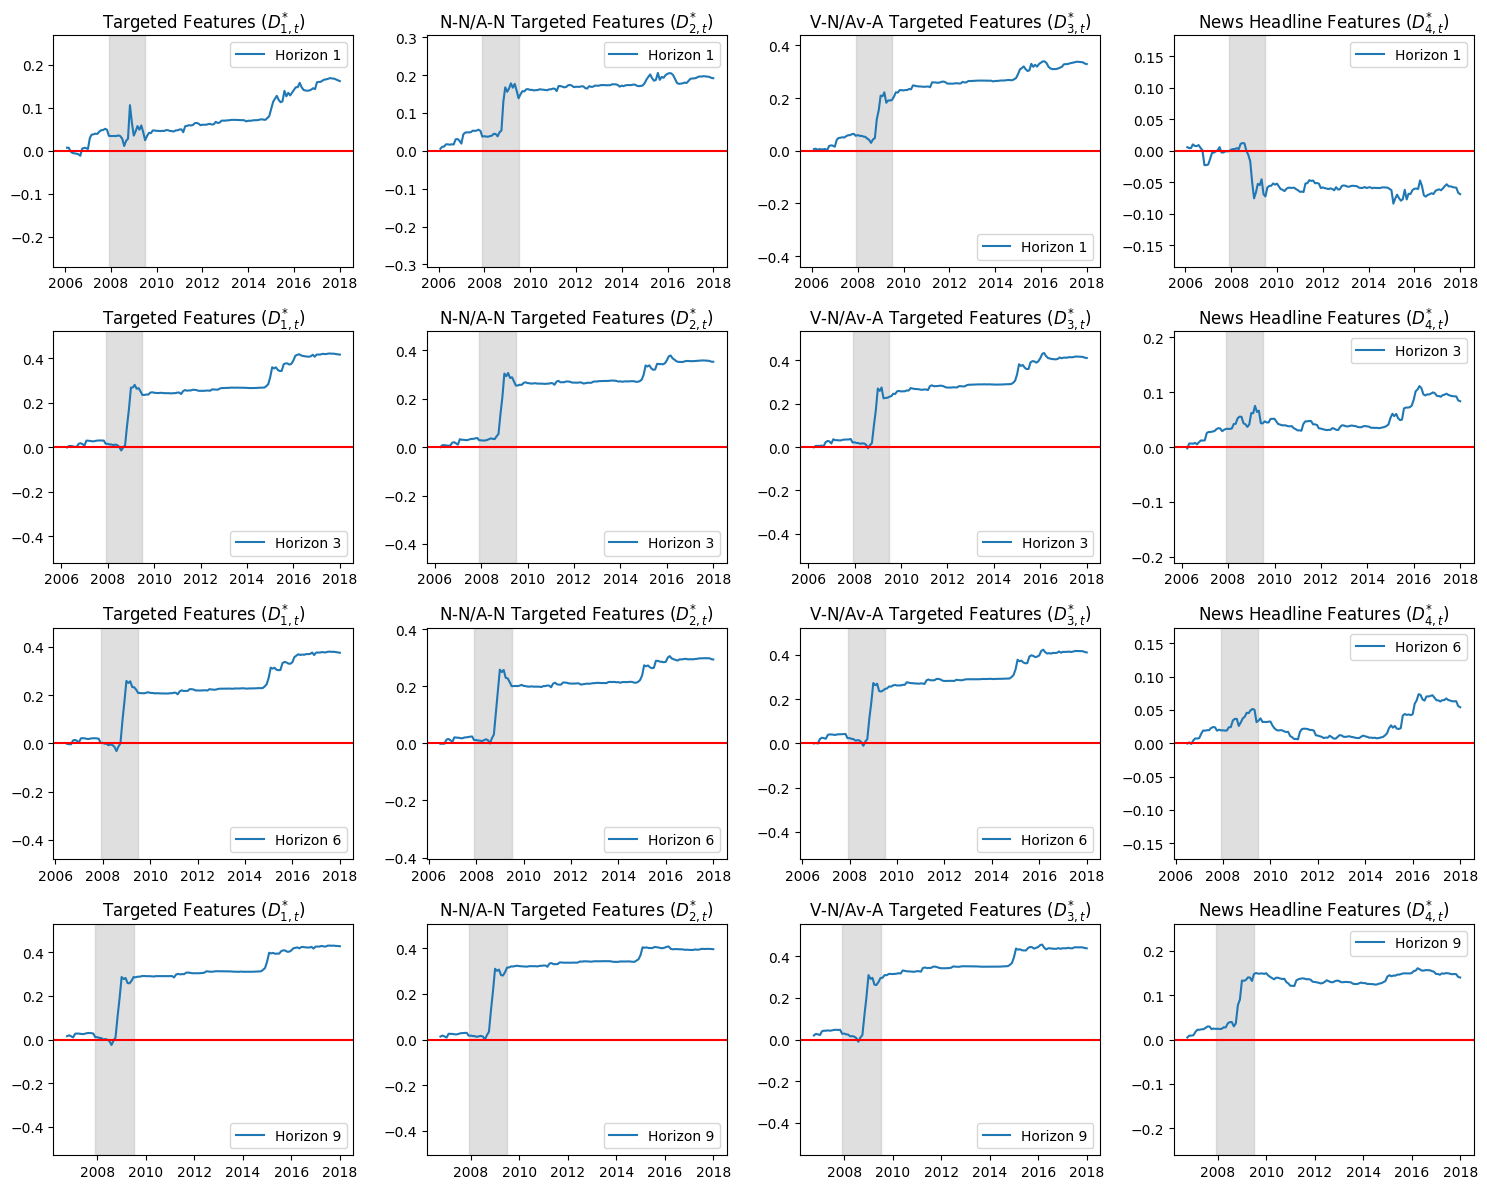

In [45]:
# Get list of models
models = list(predictions_dict_pca.keys())

# Dates of the Great Recession (according to NBER)
recession_start = pd.to_datetime('2007-12-01')
recession_end = pd.to_datetime('2009-06-30')

# The number of unique horizons
n_horizons = len(horizons)

# The number of unique models
n_models = len(models)

# Create grid of subplots: n_horizons rows and n_models columns
fig, axs = plt.subplots(n_horizons, n_models, figsize=(15, 3 * n_horizons))
axs = axs.ravel()  # Flatten array to easily iterate over it in a single loop

# Loop over each horizon
for h_idx, h in enumerate(horizons):
    # Loop over each model
    for m_idx, model_name in enumerate(models):
        ax = axs[n_models * h_idx + m_idx]  # Assign subplot position

        # Get AutoRegressive predictions for this model
        y_benchmark = np.array(predictions_ar_dict[model_name][h])

        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_ar_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])

        e1 = (y_true - y_pred) ** 2  # forecast errors from your model
        e2 = (y_true - y_benchmark) ** 2  # forecast errors from the benchmark model

        # Calculate CSPE for the model and benchmark
        cspe_model = np.cumsum(e1)
        cspe_benchmark = np.cumsum(e2)

        # Adjust dates based on the horizon
        dates = oos_base_dates[h-1:]

        # Plot CSPE
        y_values = cspe_benchmark - cspe_model
        ax.plot(dates, y_values, label=f'Horizon {h}')

        # Add a shaded region for the recession
        ax.axvspan(recession_start, recession_end, color='silver', alpha=0.5)

        ax.axhline(0, color='red', linestyle='-')
        # Set y-limit such that 0 is in the middle
        y_abs_max = max(abs(y_values.min()), abs(y_values.max()))
        ax.set_ylim(-y_abs_max-0.1, y_abs_max+0.1)

        ax.set_title(model_name)
        ax.legend()

plt.tight_layout()
plt.savefig('elpca_ar_cspe.eps', dpi=300)
plt.show()

    Explanation for Code Block 33: Plotting CSPE Difference between Models and HA Model
This block of code visualizes the cumulative squared prediction errors (CSPE) of the models $D_{1,t}$, $D_{2,t}$, $D_{3,t}$, $D_{4,t}$, and compares them with an HA model across different forecasting horizons.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


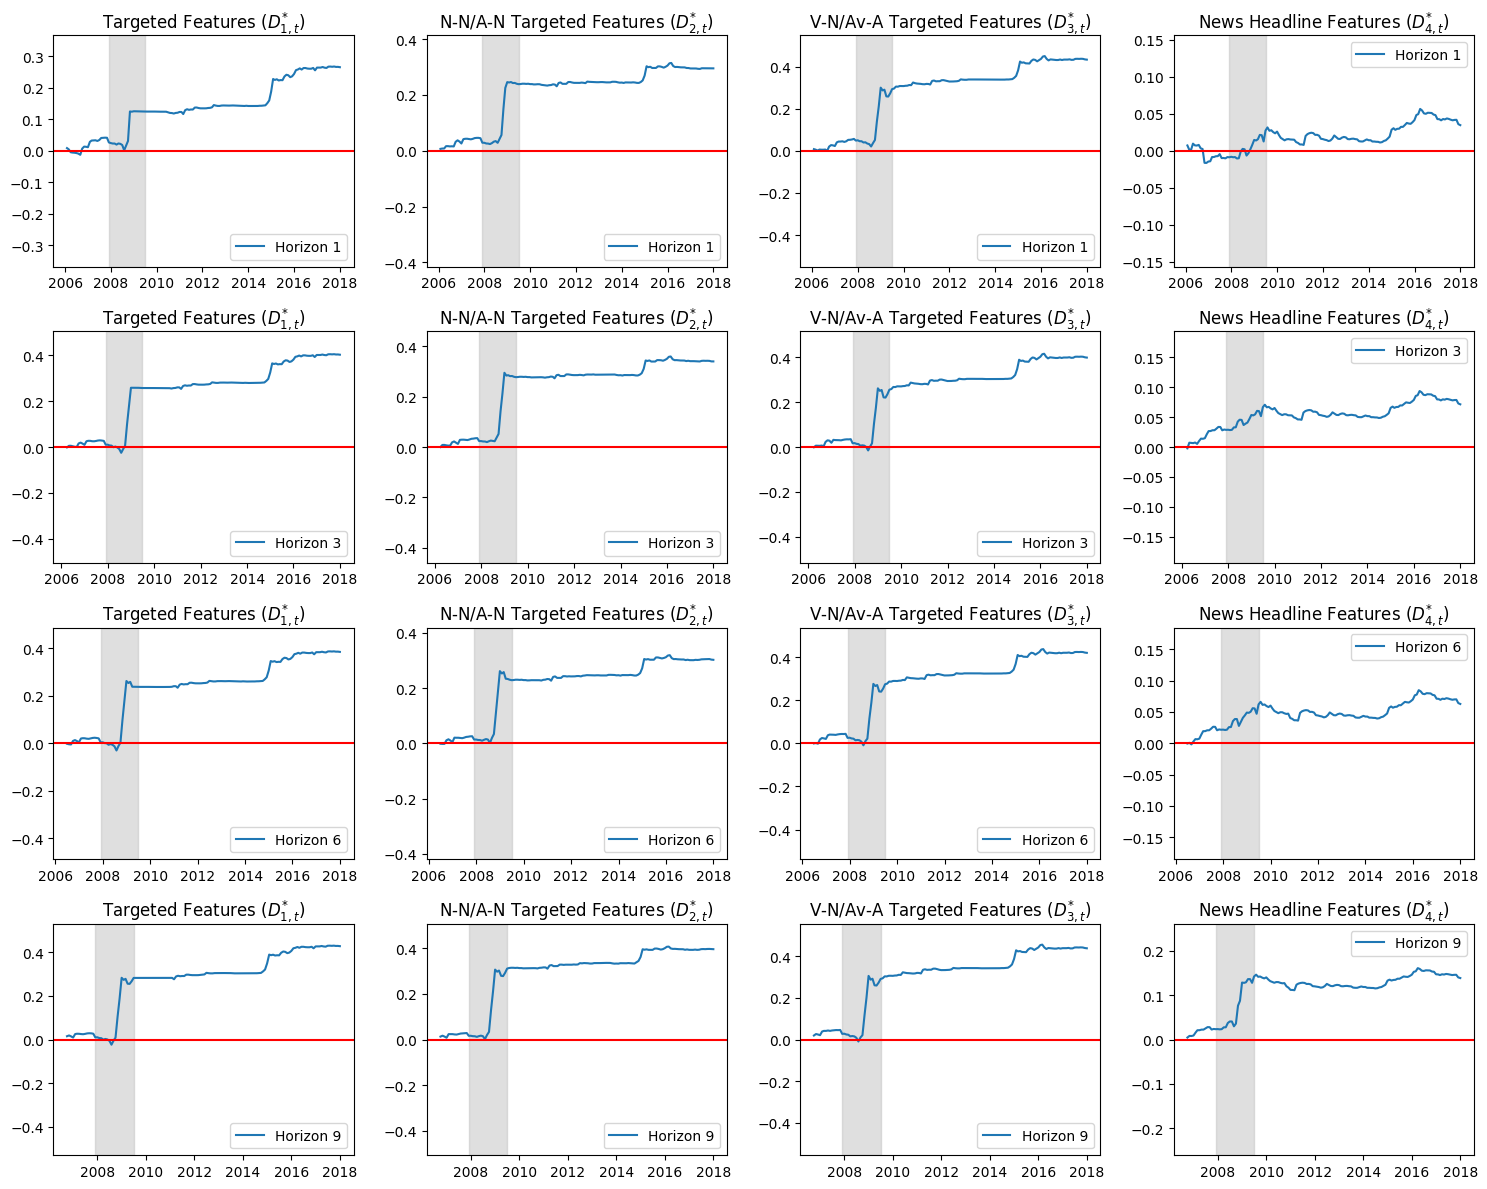

In [46]:
# Get list of models
models = list(predictions_dict_pca.keys())

# Dates of the Great Recession (according to NBER)
recession_start = pd.to_datetime('2007-12-01')
recession_end = pd.to_datetime('2009-06-30')

# The number of unique horizons
n_horizons = len(horizons)

# The number of unique models
n_models = len(models)

# Create grid of subplots: n_horizons rows and n_models columns
fig, axs = plt.subplots(n_horizons, n_models, figsize=(15, 3 * n_horizons))
axs = axs.ravel()  # Flatten array to easily iterate over it in a single loop

# Loop over each horizon
for h_idx, h in enumerate(horizons):
    # Loop over each model
    for m_idx, model_name in enumerate(models):
        ax = axs[n_models * h_idx + m_idx]  # Assign subplot position

        # Get hISTORICAL AVERAGE predictions for this model
        y_benchmark = np.array(predictions_historical_avg_dict[model_name][h])

        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_historical_avg_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca[model_name][h])

        e1 = (y_true - y_pred) ** 2  # forecast errors from your model
        e2 = (y_true - y_benchmark) ** 2  # forecast errors from the benchmark model

        # Calculate CSPE for the model and benchmark
        cspe_model = np.cumsum(e1)
        cspe_benchmark = np.cumsum(e2)

        # Adjust dates based on the horizon
        dates = oos_base_dates[h-1:]

        # Plot CSPE
        y_values = cspe_benchmark - cspe_model
        ax.plot(dates, y_values, label=f'Horizon {h}')

        # Add a shaded region for the recession
        ax.axvspan(recession_start, recession_end, color='silver', alpha=0.5)

        ax.axhline(0, color='red', linestyle='-')
        # Set y-limit such that 0 is in the middle
        y_abs_max = max(abs(y_values.min()), abs(y_values.max()))
        ax.set_ylim(-y_abs_max-0.1, y_abs_max+0.1)

        ax.set_title(model_name)
        ax.legend()

plt.tight_layout()
plt.savefig('elpca_ha_cspe.eps', dpi=300)
plt.show()

   The block of codes below are for models $D_{5,t}$, $D_{6,t}$, $D_{7,t}$, $D_{8,t}$. These are model that did not go through any pattern validation or attention mechanism. The codes are similar to those explain above. Refer accordingly.

In [47]:
# Initialize your objects
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
scaler = StandardScaler()

# Placeholder for storing all values for each horizon and each model
predictions_dict_pca_only = {}
y_true_dict_pca_only = {}

# Loop over datasets
for model_name, (train, test) in datasets2.items():
    predictions_dict_pca_only[model_name] = {h: [] for h in horizons}
    y_true_dict_pca_only[model_name] = {h: [] for h in horizons}

    # Concatenate train and test
    data = np.concatenate([train, test])

    # Loop over horizons
    for h in horizons:
        y_true_per_pca_only_horizon = []
        y_pred_per_pca_only_horizon = []

        # Loop over time points in the test set
        for i in range(len(train), len(data) - h + 1):
            # Get train and test data up to the forecast origin
            train_temp = data[:i]
            test_temp = data[i:i+h]

            # Get the corresponding targets
            y_train_temp = Target[:i]
            y_test_temp = Target[i:i+h]
            
            # Standardize the data
            scaler.fit(train_temp)
            train_temp_standardized = scaler.transform(train_temp)
            test_temp_standardized = scaler.transform(test_temp)
            
            # Now perform PCA with the chosen number of components
            n_components = num_factors(train_temp_standardized, kmax=8)
            pca = PCA(n_components= n_components)
            best_pca = pca.fit(train_temp_standardized)

            # Transform data using the best PCA
            train_temp_pca = best_pca.transform(train_temp_standardized)
            test_temp_pca = best_pca.transform(test_temp_standardized)

            # Train a linear regression model on the PCA-transformed data
            lr = LinearRegression()
            lr.fit(train_temp_pca, np.ravel(y_train_temp))
            
            # Make a prediction and add it to the predictions list
            y_pred_pca_temp = lr.predict(test_temp_pca)
            y_pred_per_pca_only_horizon.append(y_pred_pca_temp[h-1])

            # Convert true values to a list
            y_true_per_pca_only_horizon.append(y_test_temp[h-1])

        # Store predictions and true values for this horizon
        predictions_dict_pca_only[model_name][h] = y_pred_per_pca_only_horizon
        y_true_dict_pca_only[model_name][h] = y_true_per_pca_only_horizon

# Save dictionaries to files for future use
with open('predictions_dict_pca_only.pkl', 'wb') as f:
    pickle.dump(predictions_dict_pca_only, f)

    HISTORICAL AVERAGE BENCHMARK

In [48]:
# Placeholder for storing all values for each horizon and each model
predictions_historical_avg_pca_only_dict = {}
y_true_historical_avg_pca_only_dict = {}

# Loop over datasets
for model_name, (train, test) in datasets2.items():
    predictions_historical_avg_pca_only_dict[model_name] = {h: [] for h in horizons}
    y_true_historical_avg_pca_only_dict[model_name] = {h: [] for h in horizons}

    # Concatenate train and test
    data = np.concatenate([train, test])

    # Loop over horizons
    for h in horizons:
        y_true_historical_per_pca_only_horizon = []
        y_pred_historical_per_pca_only_horizon = []

        # Loop over time points in the test set
        for i in range(len(train), len(data) - h + 1):
            # Get the corresponding targets
            y_train_temp = Target[:i]
            y_test_temp = Target[i:i+h]

            # Compute historical average
            historical_avg = np.mean(y_train_temp)

            # Use historical average as prediction
            y_pred_temp = np.full(h, historical_avg)

            # Append prediction and true value to lists
            y_pred_historical_per_pca_only_horizon.append(y_pred_temp[h-1])
            y_true_historical_per_pca_only_horizon.append(y_test_temp[h-1])

        # Store predictions and true values for this horizon
        predictions_historical_avg_pca_only_dict[model_name][h] = y_pred_historical_per_pca_only_horizon
        y_true_historical_avg_pca_only_dict[model_name][h] = y_true_historical_per_pca_only_horizon 

# Save dictionaries to files for future use
with open('predictions_historical_avg_pca_only_dict.pkl', 'wb') as f:
    pickle.dump(predictions_historical_avg_pca_only_dict, f)
with open('y_true_historical_avg_pca_only_dict.pkl', 'wb') as f:
    pickle.dump(y_true_historical_avg_pca_only_dict, f)

    AUTOREGRESSIVE BENCHMARK ($AR$) BENCHMARK MODEL

In [49]:
# Placeholder for storing all values for each horizon and each model
predictions_ar_pca_only_dict = {}
y_true_ar_pca_only_dict = {}

# Loop over datasets
for model_name, (train, test) in datasets2.items():
    predictions_ar_pca_only_dict[model_name] = {h: [] for h in horizons}
    y_true_ar_pca_only_dict[model_name] = {h: [] for h in horizons}

    # Concatenate train and test
    data = np.concatenate([train, test])

    # Loop over horizons
    for h in horizons:
        y_true_per_ar_horizon = []
        y_pred_per_ar_horizon = []

        # Loop over time points in the test set
        for i in range(len(train), len(data) - h + 1):
            # Get the corresponding targets
            y_train_temp = Target[:i]
            y_test_temp = Target[i:i+h]

            # Determine the order of the AR model using AIC
            AIC = []
            for p in range(1, 10):  # for simplicity, consider orders up to 10
                model_temp = AutoReg(y_train_temp, lags=p, old_names=False)
                result_temp = model_temp.fit()
                AIC.append(result_temp.aic)
            optimal_p = np.argmin(AIC) + 1

            # Fit the AR model of order optimal_p
            model_ar = AutoReg(y_train_temp, lags=optimal_p, old_names=False)
            result_ar = model_ar.fit()

            # Make a prediction and add it to the predictions list
            y_pred_temp = result_ar.predict(start=len(y_train_temp), end=len(y_train_temp)+h-1)
            y_pred_per_ar_horizon.append(y_pred_temp[h-1])

            # Append true value to list
            y_true_per_ar_horizon.append(y_test_temp[h-1])

        # Store predictions and true values for this horizon
        predictions_ar_pca_only_dict[model_name][h] = y_pred_per_ar_horizon
        y_true_ar_pca_only_dict[model_name][h] = y_true_per_ar_horizon 

# Save dictionaries to files for future use
with open('predictions_ar_dict.pkl', 'wb') as f:
    pickle.dump(predictions_ar_dict, f)
with open('y_true_ar_dict.pkl', 'wb') as f:
    pickle.dump(y_true_ar_dict, f)

    RELATIVE ROOT MEAN SQUARED ERROR (HISTORICAL AVERAGE)

In [50]:
# Placeholder for storing RMSFE for each horizon and each model
rmsfe_dict_pca_only = {}
rrmsfe_dict_pca_only = {}

# Loop over datasets
for model_name, _ in datasets2.items():
    rmsfe_dict_pca_only[model_name] = {h: 0 for h in horizons}
    rrmsfe_dict_pca_only[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_historical_avg_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_historical_avg_pca_only_dict[model_name][h])
        
        # Calculate MSFE for this model and benchmark model
        msfe_model = np.mean((y_true - y_pred)**2)
        msfe_benchmark = np.mean((y_true - y_benchmark)**2)

        rmsfe_model = sqrt(msfe_model)
        
        # Calculate RRMSFE for this model
        rrmsfe_model = sqrt(msfe_model / msfe_benchmark)

        # Store MSFE and RRMSFE for this horizon
        rmsfe_dict_pca_only[model_name][h] = rmsfe_model
        rrmsfe_dict_pca_only[model_name][h] = rrmsfe_model

print("\nRelative Root Mean Squared Forecast Errors (RRMSFE) against HA:")
for model_name, rrmsfe_values in rrmsfe_dict_pca_only.items():
    print(f"\nModel: {model_name}")
    for h, rrmsfe in rrmsfe_values.items():
        print(f"Horizon {h}: {rrmsfe:.3f}")  # .4f is for displaying only up to 4 decimal places


Relative Root Mean Squared Forecast Errors (RRMSFE) against HA:

Model: Unigram Features ($D_{5,t}$)
Horizon 1: 1.010
Horizon 3: 1.014
Horizon 6: 1.016
Horizon 9: 1.013

Model: Fixed Dictionary Features ($D_{6,t}$)
Horizon 1: 1.006
Horizon 3: 1.007
Horizon 6: 1.008
Horizon 9: 1.008

Model: Untargeted FRED-MD Features ($D_{7,t}$)
Horizon 1: 1.037
Horizon 3: 1.097
Horizon 6: 1.089
Horizon 9: 1.039

Model: Untargeted Features ($D_{8,t}$)
Horizon 1: 1.008
Horizon 3: 1.010
Horizon 6: 1.012
Horizon 9: 1.011


    RELATIVE ROOT MEAN SQUARED ERROR (AUTOREGRESSIVE MODEL)

In [51]:
# Placeholder for storing RMSFE for each horizon and each model
rmsfe_dict = {}
rrmsfe_dict = {}

# Loop over datasets
for model_name, _ in datasets2.items():
    rmsfe_dict[model_name] = {h: 0 for h in horizons}
    rrmsfe_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_ar_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_pca_only_dict[model_name][h])
        
        # Calculate MSFE for this model and benchmark model
        msfe_model = np.mean((y_true - y_pred)**2)
        msfe_benchmark = np.mean((y_true - y_benchmark)**2)

        rmsfe_model = sqrt(msfe_model)
        
        # Calculate RRMSFE for this model
        rrmsfe_model = sqrt(msfe_model / msfe_benchmark)

        # Store MSFE and RRMSFE for this horizon
        rmsfe_dict[model_name][h] = rmsfe_model
        rrmsfe_dict[model_name][h] = rrmsfe_model

print("\nRelative Root Mean Squared Forecast Errors (RRMSFE) against AR(p):")
for model_name, rrmsfe_values in rrmsfe_dict.items():
    print(f"\nModel: {model_name}")
    for h, rrmsfe in rrmsfe_values.items():
        print(f"Horizon {h}: {rrmsfe:.3f}")  # .4f is for displaying only up to 4 decimal places


Relative Root Mean Squared Forecast Errors (RRMSFE) against AR(p):

Model: Unigram Features ($D_{5,t}$)
Horizon 1: 1.056
Horizon 3: 1.008
Horizon 6: 1.019
Horizon 9: 1.013

Model: Fixed Dictionary Features ($D_{6,t}$)
Horizon 1: 1.052
Horizon 3: 1.002
Horizon 6: 1.012
Horizon 9: 1.007

Model: Untargeted FRED-MD Features ($D_{7,t}$)
Horizon 1: 1.085
Horizon 3: 1.092
Horizon 6: 1.093
Horizon 9: 1.038

Model: Untargeted Features ($D_{8,t}$)
Horizon 1: 1.054
Horizon 3: 1.005
Horizon 6: 1.016
Horizon 9: 1.011


    OUT OF SAMPLE **R^{2}**

In [52]:
# Placeholder for storing o-o-s R-squared for each horizon and each model
r2_oos_dict = {}

# Loop over each model
for model_name in predictions_dict_pca_only.keys():
    r2_oos_dict[model_name] = {}
    # Loop over each horizon
    for h in horizons:
        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_historical_avg_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])

        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_historical_avg_pca_only_dict[model_name][h])

        # Calculate MSPE for the model and benchmark
        mspe_model = np.mean((y_true - y_pred)**2)
        mspe_benchmark = np.mean((y_true - y_benchmark)**2)

        # Calculate R^2_oos
        r2_oos = (1 - (mspe_model / mspe_benchmark))*100

        r2_oos_dict[model_name][h] = r2_oos

print("\nOut-of-sample R-squared (OOS-Rsq) against HA:")
for model_name, oos_values in r2_oos_dict.items():
    print(f"\nModel: {model_name}")
    for h, oos in oos_values.items():
        print(f"Horizon {h}: {oos:.2f}")  # .4f is for displaying only up to 4 decimal places


Out-of-sample R-squared (OOS-Rsq) against HA:

Model: Unigram Features ($D_{5,t}$)
Horizon 1: -2.00
Horizon 3: -2.72
Horizon 6: -3.16
Horizon 9: -2.69

Model: Fixed Dictionary Features ($D_{6,t}$)
Horizon 1: -1.14
Horizon 3: -1.42
Horizon 6: -1.69
Horizon 9: -1.51

Model: Untargeted FRED-MD Features ($D_{7,t}$)
Horizon 1: -7.58
Horizon 3: -20.38
Horizon 6: -18.55
Horizon 9: -7.90

Model: Untargeted Features ($D_{8,t}$)
Horizon 1: -1.66
Horizon 3: -2.09
Horizon 6: -2.50
Horizon 9: -2.28


In [53]:
# Placeholder for storing o-o-s R-squared for each horizon and each model
r2_oos_dict = {}

# Loop over each model
for model_name in predictions_dict_pca_only.keys():
    r2_oos_dict[model_name] = {}
    # Loop over each horizon
    for h in horizons:
        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_ar_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])

        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_pca_only_dict[model_name][h])

        # Calculate MSPE for the model and benchmark
        mspe_model = np.mean((y_true - y_pred)**2)
        mspe_benchmark = np.mean((y_true - y_benchmark)**2)

        # Calculate R^2_oos
        r2_oos = (1 - (mspe_model / mspe_benchmark))*100

        r2_oos_dict[model_name][h] = r2_oos

print("\nOut-of-sample R-squared (OOS-Rsq) against AR(p):")
for model_name, oos_values in r2_oos_dict.items():
    print(f"\nModel: {model_name}")
    for h, oos in oos_values.items():
        print(f"Horizon {h}: {oos:.2f}")  # .4f is for displaying only up to 4 decimal places


Out-of-sample R-squared (OOS-Rsq) against AR(p):

Model: Unigram Features ($D_{5,t}$)
Horizon 1: -11.52
Horizon 3: -1.70
Horizon 6: -3.91
Horizon 9: -2.62

Model: Fixed Dictionary Features ($D_{6,t}$)
Horizon 1: -10.59
Horizon 3: -0.41
Horizon 6: -2.43
Horizon 9: -1.44

Model: Untargeted FRED-MD Features ($D_{7,t}$)
Horizon 1: -17.62
Horizon 3: -19.18
Horizon 6: -19.42
Horizon 9: -7.82

Model: Untargeted Features ($D_{8,t}$)
Horizon 1: -11.15
Horizon 3: -1.07
Horizon 6: -3.25
Horizon 9: -2.20


In [54]:
# Placeholder for storing DM test results for each horizon and each model
dm_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets2.items():
    dm_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_ar_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_pca_only_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Perform the Diebold-Mariano test
        dm_stat, p_value = dm_test(y_true, y_pred, y_benchmark, one_sided = True)

        # Store the DM test results
        dm_test_results_dict[model_name][h] = (dm_stat, p_value) # Negative for greater than one-sided

print("\nDiebold-Mariano test results aginst AR(p):")
for model_name, dm_results in dm_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (dm_stat, p_value) in dm_results.items():
        print(f"Horizon {h}: DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Diebold-Mariano test results aginst AR(p):

Model: Unigram Features ($D_{5,t}$)
Horizon 1: DM Statistic: 1.508, p-value: 0.933
Horizon 3: DM Statistic: 0.400, p-value: 0.655
Horizon 6: DM Statistic: 1.270, p-value: 0.897
Horizon 9: DM Statistic: 1.556, p-value: 0.939

Model: Fixed Dictionary Features ($D_{6,t}$)
Horizon 1: DM Statistic: 1.421, p-value: 0.921
Horizon 3: DM Statistic: 0.100, p-value: 0.540
Horizon 6: DM Statistic: 0.858, p-value: 0.804
Horizon 9: DM Statistic: 1.085, p-value: 0.860

Model: Untargeted FRED-MD Features ($D_{7,t}$)
Horizon 1: DM Statistic: 1.731, p-value: 0.957
Horizon 3: DM Statistic: 1.776, p-value: 0.961
Horizon 6: DM Statistic: 2.421, p-value: 0.992
Horizon 9: DM Statistic: 2.119, p-value: 0.982

Model: Untargeted Features ($D_{8,t}$)
Horizon 1: DM Statistic: 1.484, p-value: 0.930
Horizon 3: DM Statistic: 0.257, p-value: 0.601
Horizon 6: DM Statistic: 1.100, p-value: 0.863
Horizon 9: DM Statistic: 1.475, p-value: 0.929


In [55]:
# Placeholder for storing Clark-West test results for each horizon and each model
cw_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets2.items():
    cw_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_ar_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_ar_pca_only_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Compute the loss difference
        d = (benchmark_errors ** 2) - (model_errors ** 2)

        # Compute the extra term for Clark-West test
        cw_extra_term = (benchmark_errors - model_errors) ** 2

        # Perform the Clark-West test
        cw_stat = d.mean() / (np.sqrt((d - cw_extra_term).var() / len(d)))

        # Since the Clark-West test is one-sided, we take the complement of the cumulative distribution function
        p_value = 1 - stats.norm.cdf(cw_stat)

        # Store the Clark-West test results
        cw_test_results_dict[model_name][h] = (cw_stat, p_value)

print("\nClark-West test results against AR(p):")
for model_name, cw_results in cw_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (cw_stat, p_value) in cw_results.items():
        print(f"Horizon {h}: CW Statistic: {cw_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Clark-West test results against AR(p):

Model: Unigram Features ($D_{5,t}$)
Horizon 1: CW Statistic: -1.387, p-value: 0.917
Horizon 3: CW Statistic: -0.385, p-value: 0.650
Horizon 6: CW Statistic: -1.278, p-value: 0.899
Horizon 9: CW Statistic: -1.522, p-value: 0.936

Model: Fixed Dictionary Features ($D_{6,t}$)
Horizon 1: CW Statistic: -1.311, p-value: 0.905
Horizon 3: CW Statistic: -0.097, p-value: 0.539
Horizon 6: CW Statistic: -0.876, p-value: 0.810
Horizon 9: CW Statistic: -1.077, p-value: 0.859

Model: Untargeted FRED-MD Features ($D_{7,t}$)
Horizon 1: CW Statistic: -1.326, p-value: 0.908
Horizon 3: CW Statistic: -1.259, p-value: 0.896
Horizon 6: CW Statistic: -1.862, p-value: 0.969
Horizon 9: CW Statistic: -1.810, p-value: 0.965

Model: Untargeted Features ($D_{8,t}$)
Horizon 1: CW Statistic: -1.366, p-value: 0.914
Horizon 3: CW Statistic: -0.248, p-value: 0.598
Horizon 6: CW Statistic: -1.111, p-value: 0.867
Horizon 9: CW Statistic: -1.448, p-value: 0.926


In [56]:
# Placeholder for storing DM test results for each horizon and each model
dm_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets2.items():
    dm_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_historical_avg_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_historical_avg_pca_only_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Perform the Diebold-Mariano test
        dm_stat, p_value = dm_test(y_true, y_pred, y_benchmark, one_sided = True)

        # Store the DM test results
        dm_test_results_dict[model_name][h] = (dm_stat, p_value) # Negative for greater than one-sided

print("\nDiebold-Mariano test results aginst HA:")
for model_name, dm_results in dm_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (dm_stat, p_value) in dm_results.items():
        print(f"Horizon {h}: DM Statistic: {dm_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Diebold-Mariano test results aginst HA:

Model: Unigram Features ($D_{5,t}$)
Horizon 1: DM Statistic: 1.176, p-value: 0.879
Horizon 3: DM Statistic: 1.533, p-value: 0.936
Horizon 6: DM Statistic: 1.723, p-value: 0.956
Horizon 9: DM Statistic: 1.492, p-value: 0.931

Model: Fixed Dictionary Features ($D_{6,t}$)
Horizon 1: DM Statistic: 0.820, p-value: 0.793
Horizon 3: DM Statistic: 1.009, p-value: 0.843
Horizon 6: DM Statistic: 1.206, p-value: 0.885
Horizon 9: DM Statistic: 1.090, p-value: 0.861

Model: Untargeted FRED-MD Features ($D_{7,t}$)
Horizon 1: DM Statistic: 0.930, p-value: 0.823
Horizon 3: DM Statistic: 2.426, p-value: 0.992
Horizon 6: DM Statistic: 2.809, p-value: 0.997
Horizon 9: DM Statistic: 1.988, p-value: 0.976

Model: Untargeted Features ($D_{8,t}$)
Horizon 1: DM Statistic: 1.068, p-value: 0.856
Horizon 3: DM Statistic: 1.329, p-value: 0.907
Horizon 6: DM Statistic: 1.576, p-value: 0.941
Horizon 9: DM Statistic: 1.444, p-value: 0.925


In [57]:
# Placeholder for storing Clark-West test results for each horizon and each model
cw_test_results_dict = {}

# Loop over datasets
for model_name, _ in datasets2.items():
    cw_test_results_dict[model_name] = {h: 0 for h in horizons}

    # Loop over horizons
    for h in horizons:
        # Get true values and predictions for this horizon
        y_true = np.array(y_true_historical_avg_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])
        
        # Calculate benchmark predictions (AutoRegressive model)
        y_benchmark = np.array(predictions_historical_avg_pca_only_dict[model_name][h])
        
        # Compute the prediction errors
        model_errors = y_true - y_pred
        benchmark_errors = y_true - y_benchmark

        # Compute the loss difference
        d = (benchmark_errors ** 2) - (model_errors ** 2)

        # Compute the extra term for Clark-West test
        cw_extra_term = (benchmark_errors - model_errors) ** 2

        # Perform the Clark-West test
        cw_stat = d.mean() / (np.sqrt((d - cw_extra_term).var() / len(d)))

        # Since the Clark-West test is one-sided, we take the complement of the cumulative distribution function
        p_value = 1 - stats.norm.cdf(cw_stat)

        # Store the Clark-West test results
        cw_test_results_dict[model_name][h] = (cw_stat, p_value)

print("\nClark-West test results against HA:")
for model_name, cw_results in cw_test_results_dict.items():
    print(f"\nModel: {model_name}")
    for h, (cw_stat, p_value) in cw_results.items():
        print(f"Horizon {h}: CW Statistic: {cw_stat:.3f}, p-value: {p_value:.3f}")  # .3f is for displaying only up to 3 decimal places


Clark-West test results against HA:

Model: Unigram Features ($D_{5,t}$)
Horizon 1: CW Statistic: -1.162, p-value: 0.877
Horizon 3: CW Statistic: -1.507, p-value: 0.934
Horizon 6: CW Statistic: -1.676, p-value: 0.953
Horizon 9: CW Statistic: -1.448, p-value: 0.926

Model: Fixed Dictionary Features ($D_{6,t}$)
Horizon 1: CW Statistic: -0.809, p-value: 0.791
Horizon 3: CW Statistic: -0.992, p-value: 0.839
Horizon 6: CW Statistic: -1.183, p-value: 0.882
Horizon 9: CW Statistic: -1.072, p-value: 0.858

Model: Untargeted FRED-MD Features ($D_{7,t}$)
Horizon 1: CW Statistic: -0.821, p-value: 0.794
Horizon 3: CW Statistic: -1.934, p-value: 0.973
Horizon 6: CW Statistic: -2.317, p-value: 0.990
Horizon 9: CW Statistic: -1.625, p-value: 0.948

Model: Untargeted Features ($D_{8,t}$)
Horizon 1: CW Statistic: -1.059, p-value: 0.855
Horizon 3: CW Statistic: -1.312, p-value: 0.905
Horizon 6: CW Statistic: -1.538, p-value: 0.938
Horizon 9: CW Statistic: -1.410, p-value: 0.921


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


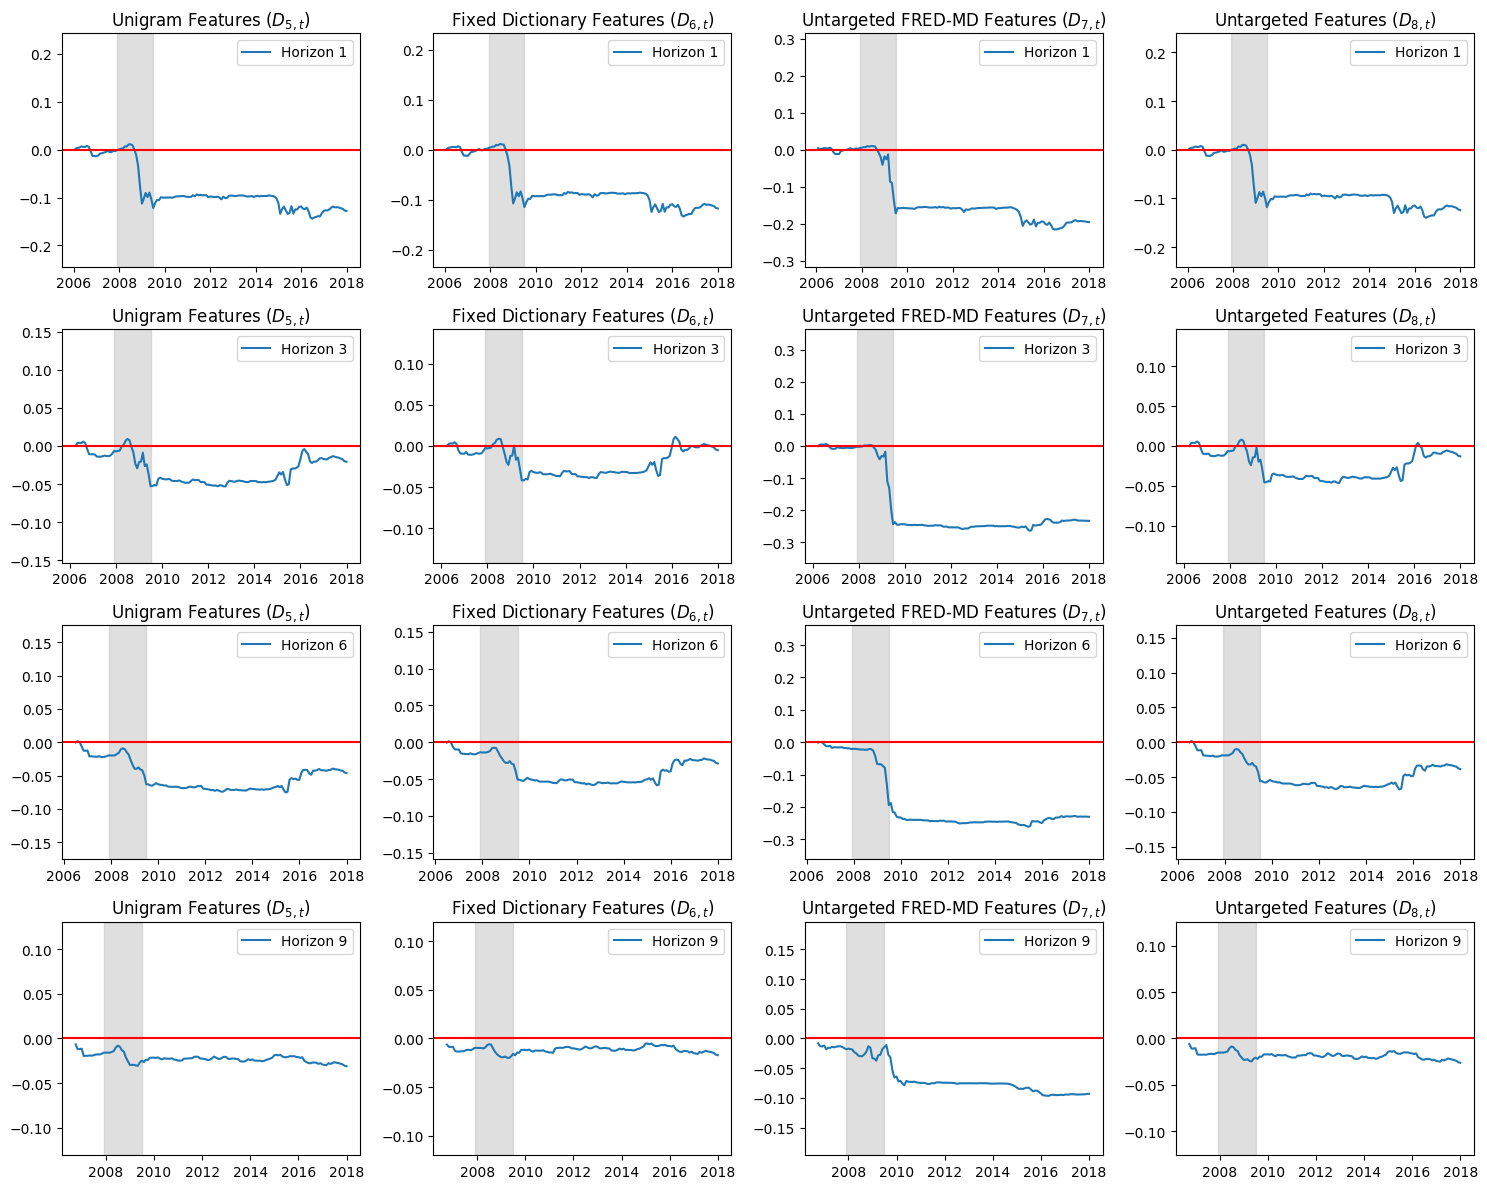

In [58]:
# Get list of models
models = list(predictions_dict_pca_only.keys())

# Dates of the Great Recession (according to NBER)
recession_start = pd.to_datetime('2007-12-01')
recession_end = pd.to_datetime('2009-06-30')

# The number of unique horizons
n_horizons = len(horizons)

# The number of unique models
n_models = len(models)

# Create grid of subplots: n_horizons rows and n_models columns
fig, axs = plt.subplots(n_horizons, n_models, figsize=(15, 3 * n_horizons))
axs = axs.ravel()  # Flatten array to easily iterate over it in a single loop

# Loop over each horizon
for h_idx, h in enumerate(horizons):
    # Loop over each model
    for m_idx, model_name in enumerate(models):
        ax = axs[n_models * h_idx + m_idx]  # Assign subplot position

        # Get AutoRegressive predictions for this model
        y_benchmark = np.array(predictions_ar_pca_only_dict[model_name][h])

        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_ar_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])

        e1 = (y_true - y_pred) ** 2  # forecast errors from your model
        e2 = (y_true - y_benchmark) ** 2  # forecast errors from the benchmark model

        # Calculate CSPE for the model and benchmark
        cspe_model = np.cumsum(e1)
        cspe_benchmark = np.cumsum(e2)

        # Adjust dates based on the horizon
        dates = oos_base_dates[h-1:]

        # Plot CSPE
        y_values = cspe_benchmark - cspe_model
        ax.plot(dates, y_values, label=f'Horizon {h}')

        # Add a shaded region for the recession
        ax.axvspan(recession_start, recession_end, color='silver', alpha=0.5)

        ax.axhline(0, color='red', linestyle='-')
        # Set y-limit such that 0 is in the middle
        y_abs_max = max(abs(y_values.min()), abs(y_values.max()))
        ax.set_ylim(-y_abs_max-0.1, y_abs_max+0.1)

        ax.set_title(model_name)
        ax.legend()

plt.tight_layout()
plt.savefig('pca_ar_cspe.eps', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


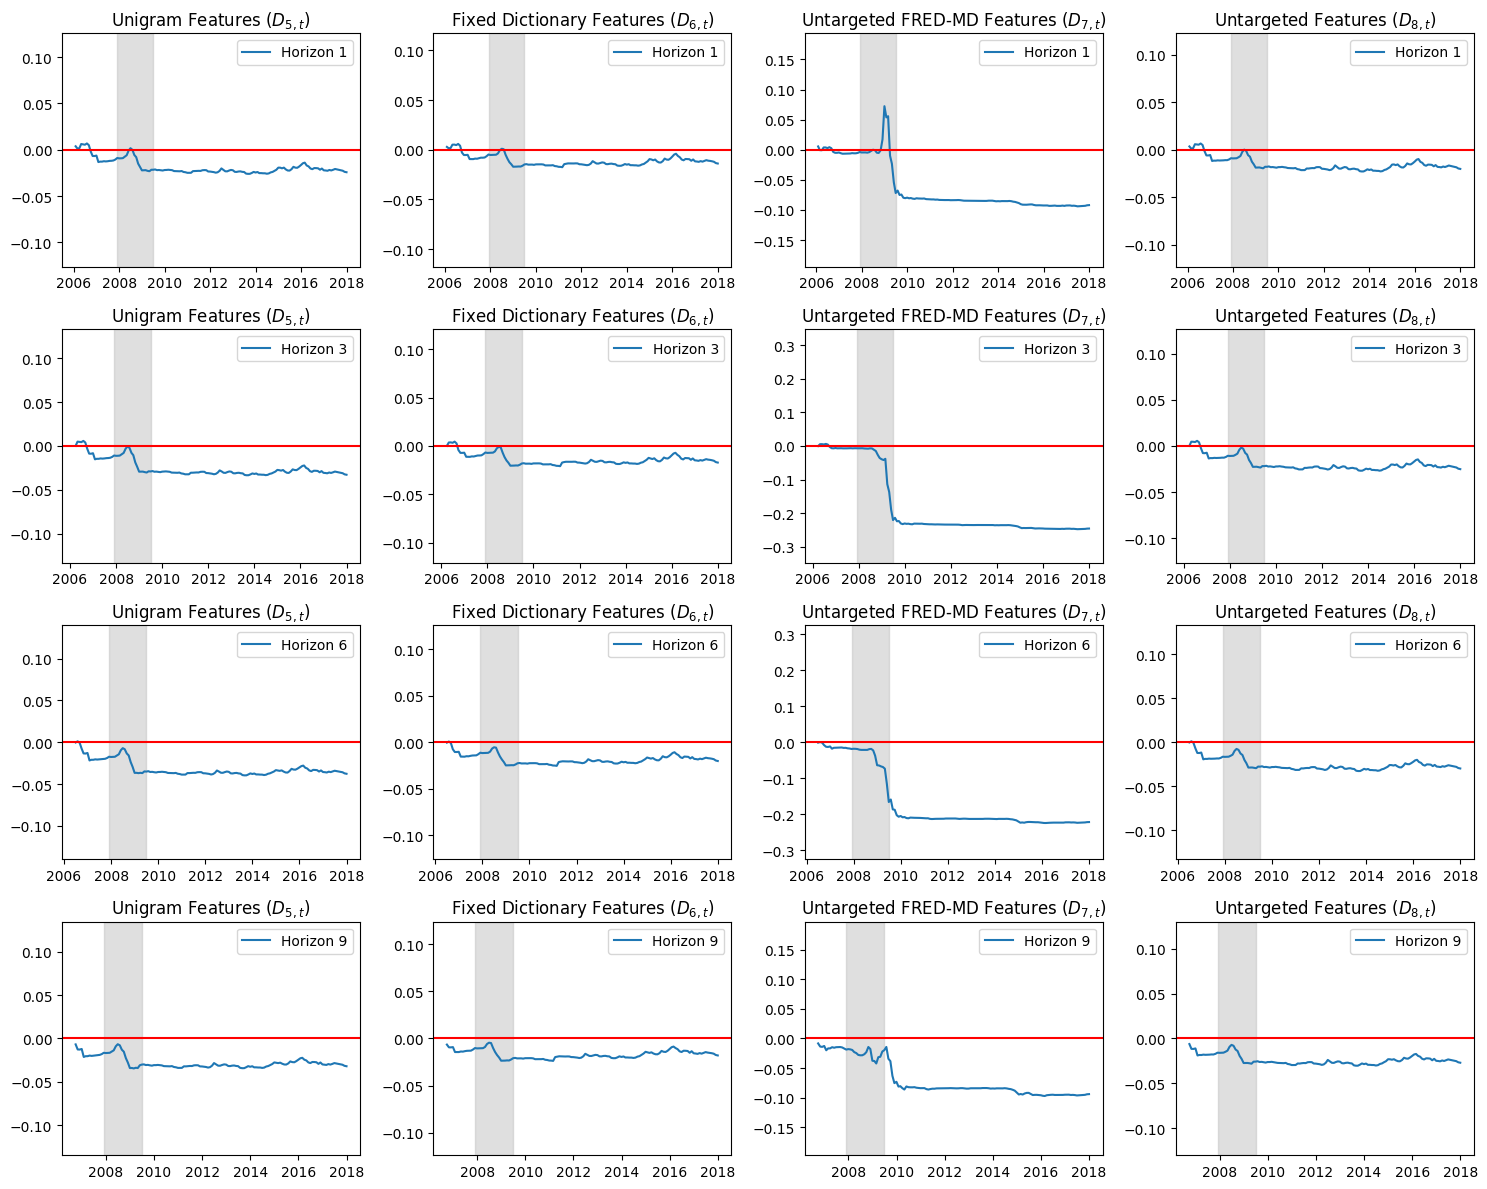

In [59]:
# Get list of models
models = list(predictions_dict_pca_only.keys())

# Dates of the Great Recession (according to NBER)
recession_start = pd.to_datetime('2007-12-01')
recession_end = pd.to_datetime('2009-06-30')

# The number of unique horizons
n_horizons = len(horizons)

# The number of unique models
n_models = len(models)

# Create grid of subplots: n_horizons rows and n_models columns
fig, axs = plt.subplots(n_horizons, n_models, figsize=(15, 3 * n_horizons))
axs = axs.ravel()  # Flatten array to easily iterate over it in a single loop

# Loop over each horizon
for h_idx, h in enumerate(horizons):
    # Loop over each model
    for m_idx, model_name in enumerate(models):
        ax = axs[n_models * h_idx + m_idx]  # Assign subplot position

        # Get AutoRegressive predictions for this model
        y_benchmark = np.array(predictions_historical_avg_pca_only_dict[model_name][h])

        # Get true values and predictions for this model and horizon
        y_true = np.array(y_true_historical_avg_pca_only_dict[model_name][h])
        y_pred = np.array(predictions_dict_pca_only[model_name][h])

        e1 = (y_true - y_pred) ** 2  # forecast errors from your model
        e2 = (y_true - y_benchmark) ** 2  # forecast errors from the benchmark model

        # Calculate CSPE for the model and benchmark
        cspe_model = np.cumsum(e1)
        cspe_benchmark = np.cumsum(e2)

        # Adjust dates based on the horizon
        dates = oos_base_dates[h-1:]

        # Plot CSPE
        y_values = cspe_benchmark - cspe_model
        ax.plot(dates, y_values, label=f'Horizon {h}')

        # Add a shaded region for the recession
        ax.axvspan(recession_start, recession_end, color='silver', alpha=0.5)

        ax.axhline(0, color='red', linestyle='-')
        # Set y-limit such that 0 is in the middle
        y_abs_max = max(abs(y_values.min()), abs(y_values.max()))
        ax.set_ylim(-y_abs_max-0.1, y_abs_max+0.1)

        ax.set_title(model_name)
        ax.legend()

plt.tight_layout()
plt.savefig('pca_ha_cspe.eps', dpi=300)
plt.show()

In [60]:
# Placeholder for storing all values for each horizon and each model
forecast_records = []
true_records = []

# Loop over each model
for model_name in predictions_dict_pca.keys():
    # Loop over each horizon
    for h in horizons:
        # Retrieve forecasts for each horizon for current model
        forecasts = predictions_dict_pca[model_name][h]
        forecasts_ar = predictions_ar_dict[model_name][h]
        forecasts_ha = predictions_historical_avg_dict[model_name][h]
        
        # Retrieve true values for each horizon for current model
        true_values = y_true_dict_pca[model_name][h]
        
        # Loop over each forecast and true value and create a new record for each
        for i in range(len(forecasts)):
            forecast_record = {
                'Model': model_name,
                'Horizon': h,
                'Forecast': forecasts[i],
                'Forecast_AR': forecasts_ar[i],
                'Forecast_HA': forecasts_ha[i]
            }
            true_record = {
                'Model': model_name,
                'Horizon': h,
                'TrueValue': true_values[i]
            }
            
            # Append the record to list
            forecast_records.append(forecast_record)
            true_records.append(true_record)

# Create DataFrames
forecast_df = pd.DataFrame(forecast_records)
true_df = pd.DataFrame(true_records)

# Save DataFrames to .csv files
forecast_df.to_csv('forecasts.csv', index=False)
true_df.to_csv('true_values.csv', index=False)

In [61]:
# Placeholder for storing all values for each horizon and each model
forecast_records = []
true_records = []

# Loop over each model
for model_name in predictions_dict_pca_only.keys():
    # Loop over each horizon
    for h in horizons:
        # Retrieve forecasts for each horizon for current model
        forecasts = predictions_dict_pca_only[model_name][h]
        forecasts_ar = predictions_ar_pca_only_dict[model_name][h]
        forecasts_ha = predictions_historical_avg_pca_only_dict[model_name][h]
        
        # Retrieve true values for each horizon for current model
        true_values = y_true_dict_pca_only[model_name][h]
        
        # Loop over each forecast and true value and create a new record for each
        for i in range(len(forecasts)):
            forecast_record = {
                'Model': model_name,
                'Horizon': h,
                'Forecast': forecasts[i],
                'Forecast_AR': forecasts_ar[i],
                'Forecast_HA': forecasts_ha[i]
            }
            true_record = {
                'Model': model_name,
                'Horizon': h,
                'TrueValue': true_values[i]
            }
            
            # Append the record to list
            forecast_records.append(forecast_record)
            true_records.append(true_record)

# Create DataFrames
forecast_df = pd.DataFrame(forecast_records)
true_df = pd.DataFrame(true_records)

# Save DataFrames to .csv files
forecast_df.to_csv('forecasts_pca_only.csv', index=False)
true_df.to_csv('true_values_pca_only.csv', index=False)